### Disclaimer: This notebook should not be considered any kind of financial advice. It exists only for the purposes of practicing modeling and making predictions

In [2]:
import yfinance as yf
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import datetime as dt
import warnings
import pandas_ta
import statsmodels.api as sm
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 25)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# Accessing the current list of S&P 500 Stocks

sp_500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]

In [3]:
sp_500.head(2)

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916


In [4]:
# Cleaning the symbols for compatability with yfinance

sp_500['Symbol'] = sp_500["Symbol"].str.replace('.', '-')

In [5]:
# Creating a consolidated list of stock symbols

stock_list = sp_500["Symbol"].unique().tolist()

### Quick Note About Surivorship Bias
This study will have a bias, in that it will not adequately reflect or address the fact that some companies do eventually fail. This gives the study a bias towards surviving companies that have not failed, and in turn, that can lead to more optimistic predictions than may in fact be realistic. Bear that in mind as you evaluate this study.

In [6]:
# Not-suvivorship bias free, meaning some stocks that no longer trade/went bankrupt will not be considered

len(stock_list)

503

In [7]:
stock_list[:5]

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN']

# Downloading the data from yfinance

In [8]:
# Download the data up to a few days ago for the past 10 years approximately not accounting for leap years

end_date = '2023-10-26'

# pd.DateOffset can calculate a specified period of time, in this case 10 intervals of 365 days 
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*10)

### YFINANCE
This makes use of an API from Yahoo! Finance, and requires arguments for: 
- Stock Tickers
- Start Date
- End Date

In [9]:
# yfinance produces a df based on symbols, start and end date

df = yf.download(tickers=stock_list, start=start_date, end=end_date)

[*********************100%%**********************]  503 of 503 completed


In [10]:
# Current shape displays each individual stock as a sub-feature, and the actual features as super-features

df.shape

(2516, 3018)

In [11]:
# 6 features accompany the raw data

df.columns.get_level_values(0).unique()

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [12]:
# Every sub-feature corresponds to the list of stock tickers

len(df.columns.get_level_values(1).unique()), df.columns.get_level_values(1).unique()[:5]

(503, Index(['A', 'AAL', 'AAPL', 'ABBV', 'ABNB'], dtype='object'))

In [13]:
# Investigating the data, find that every stock is a sub-feature, and that the columns have 6 primary indexes

df.head()

Adj Close                                                   \
                    A        AAL       AAPL       ABBV ABNB        ABT   
Date                                                                     
2013-10-28  33.811764  20.749743  16.516190  32.808750  NaN  30.737597   
2013-10-29  33.949665  21.089128  16.104752  33.054390  NaN  30.737597   
2013-10-30  33.588505  21.287104  16.360960  32.397156  NaN  30.457270   
2013-10-31  33.332401  20.712030  16.292391  32.164795  NaN  30.135710   
2013-11-01  33.555664  21.155117  16.209167  32.503380  NaN  30.473759   

                                                                              \
                 ACGL        ACN       ADBE        ADI        ADM        ADP   
Date                                                                           
2013-10-28  19.193333  62.408939  53.930000  38.017277  30.461433  53.340332   
2013-10-29  19.326668  62.904369  54.860001  39.370449  31.141935  53.819691   
2013-10-30  19.299999  62.350132  54.099998  39.058170  31.348372  52.374619   
2013-10-31  19.320000  61.720341  54.220001  39.474548  31.271902  52.889206   
2013-11-01  19.246668  61.300499  54.610001  39.778809  31.271902  53.086567   

            ...  Volume                                                \
            ...     WTW       WY     WYNN      XEL       XOM     XRAY   
Date        ...                                                         
2013-10-28  ...  170668  3988100  1176000  2971800   9921900  1037000   
2013-10-29  ...  347375  3909000   740900  2412900  10340000  1345700   
2013-10-30  ...  740353  5532000   918900  2927200  14305900  1027700   
2013-10-31  ...  508153  5022500  1056800  3095900  19185200   882000   
2013-11-01  ...  593128  3619400   816300  2164100  19023500   784100   

                                                                 
                XYL      YUM      ZBH    ZBRA     ZION      ZTS  
Date                                                             
2013-10-28  1647800  3008872  1805178  404100  1981600  3636400  
2013-10-29  7931900  2834163  1124966  247600  2092400  2912000  
2013-10-30  3006300  5355906  1238575  175600  1557100  4398600  
2013-10-31  2501000  3596431  1121155  103500  1798500  4241700  
2013-11-01  3774800  4559142  1029485  121000  1563900  5890500  

[5 rows x 3018 columns]

# Creating Multi-Index of Dates/Tickers

In [14]:
# Establish a multi-index dataframe where every day is an index and every stock is also listed for each day

df = df.stack()

In [15]:
df.head()

Adj Close      Close       High        Low       Open  \
Date                                                                     
2013-10-28 A     33.811764  36.831188  37.181686  36.566525  37.045780   
           AAL   20.749743  22.010000  22.629999  21.879999  22.240000   
           AAPL  16.516190  18.924286  18.964287  18.686071  18.894285   
           ABBV  32.808750  49.419998  49.970001  48.970001  49.130001   
           ABT   30.737597  37.279999  37.459999  37.169998  37.330002   

                      Volume  
Date                          
2013-10-28 A       2486623.0  
           AAL     4642800.0  
           AAPL  550440800.0  
           ABBV    5555000.0  
           ABT     4799700.0

In [16]:
# Re-naming the actual index titles
df.index.names = ["Date", "Ticker"]

In [17]:
# 1.234 M owbservations from the past 10 years from 503 different stocks

df.shape

(1234259, 6)

In [18]:
# Investigating new multi-index df

df.head()

Adj Close      Close       High        Low       Open  \
Date       Ticker                                                          
2013-10-28 A       33.811764  36.831188  37.181686  36.566525  37.045780   
           AAL     20.749743  22.010000  22.629999  21.879999  22.240000   
           AAPL    16.516190  18.924286  18.964287  18.686071  18.894285   
           ABBV    32.808750  49.419998  49.970001  48.970001  49.130001   
           ABT     30.737597  37.279999  37.459999  37.169998  37.330002   

                        Volume  
Date       Ticker               
2013-10-28 A         2486623.0  
           AAL       4642800.0  
           AAPL    550440800.0  
           ABBV      5555000.0  
           ABT       4799700.0

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1234259 entries, (Timestamp('2013-10-28 00:00:00'), 'A') to (Timestamp('2023-10-25 00:00:00'), 'ZTS')
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   Adj Close  1234259 non-null  float64
 1   Close      1234259 non-null  float64
 2   High       1234259 non-null  float64
 3   Low        1234259 non-null  float64
 4   Open       1234259 non-null  float64
 5   Volume     1234259 non-null  float64
dtypes: float64(6)
memory usage: 61.3+ MB


In [20]:
df["Adj Close"].isna().sum()

0

What I am left to believe is that when the data was stacked, there were dates wherein certain stocks were not yet traded on the market, such as ABNB having nulls for the first .head() display. However, when the data was stacked so that Dates and Tickers were used to index, that the dates wherein that stock was not traded no longer required feature data, therefore those cells ceased to exist. 

# Feature Engineering the Data

Now, the columns all contain numeric values, so we are more or less prepared for modeling of data. We will also add some information pertaining to technical stock market indicators. I will also Add information for the years and quarters of a presidential cycle. 

### Technical Indicators and Features : all raw and unscaled as of yet

- Garman-Klass Volatility | Inter-day Volatility 
- RSI | Relative Strength Indicator, measure of over-undersold conditions
- Bollinger Bands | Standard Deviations from moving average of specified range
- ATR | Volatility Measure
- MACD | Moving Average Convergence-Divergence
- Dollar Volume | Total dollar amount traded in a day

### Garman-Klass Volatility

In [21]:
# Daily measure of volatility, so this can be applied on a per-observation basis

df["garman_klass_vol"] = ((np.log(df['High']) - np.log(df["Low"])) ** 2)/2 - (2*np.log(2)- 1) * (np.log(df["Adj Close"])- np.log(df['Open']))**2

In [22]:
df.head()

Adj Close      Close       High        Low       Open  \
Date       Ticker                                                          
2013-10-28 A       33.811764  36.831188  37.181686  36.566525  37.045780   
           AAL     20.749743  22.010000  22.629999  21.879999  22.240000   
           AAPL    16.516190  18.924286  18.964287  18.686071  18.894285   
           ABBV    32.808750  49.419998  49.970001  48.970001  49.130001   
           ABT     30.737597  37.279999  37.459999  37.169998  37.330002   

                        Volume  garman_klass_vol  
Date       Ticker                                 
2013-10-28 A         2486623.0         -0.003084  
           AAL       4642800.0         -0.001290  
           AAPL    550440800.0         -0.006881  
           ABBV      5555000.0         -0.062775  
           ABT       4799700.0         -0.014555

### RSI 

In [23]:
df.xs("AAPL", level=1, drop_level=False)

,,Adj Close,Close,High,Low,Open,Volume,garman_klass_vol
Date,Ticker,,,,,,,
2013-10-28,AAPL,16.516190,18.924286,18.964287,18.686071,18.894285,550440800.0,-0.006881
2013-10-29,AAPL,16.104752,18.452856,19.258928,18.376429,19.152500,635807200.0,-0.010504
2013-10-30,AAPL,16.360960,18.746429,18.840000,18.465000,18.557501,354163600.0,-0.005928
2013-10-31,AAPL,16.292391,18.667856,18.838928,18.616785,18.750000,275696400.0,-0.007555
2013-11-01,AAPL,16.209167,18.572500,18.742857,18.422857,18.715000,274890000.0,-0.007834
...,...,...,...,...,...,...,...,...
2023-10-19,AAPL,175.460007,175.460007,177.839996,175.190002,176.039993,59302900.0,0.000108
2023-10-20,AAPL,172.880005,172.880005,175.419998,172.639999,175.309998,64189300.0,0.000052
2023-10-23,AAPL,173.000000,173.000000,174.009995,169.929993,170.910004,55980100.0,0.000224


### Many of the following tranformations use the ".transform()" method, which is like .apply() but more commonly used in .groupby() operations to treat each group independently

In [24]:
# Adding a feature for relative strength

df["RSI"] = df.groupby(level=1)['Adj Close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

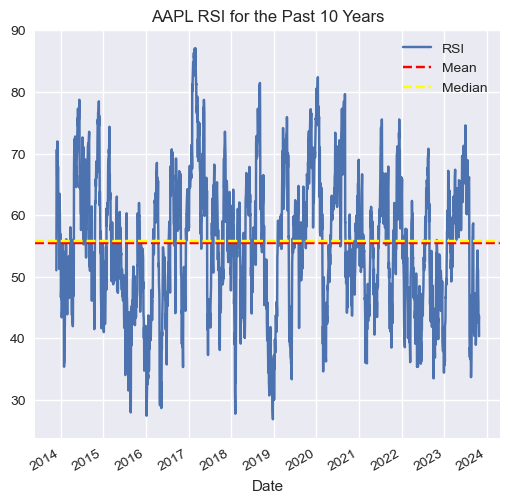

In [25]:
plt.style.use("seaborn")
fig, ax = plt.subplots(figsize=(6,6))
df.xs("AAPL", level=1)["RSI"].plot(ax=ax)
ax.axhline(df.xs("AAPL", level=1)["RSI"].mean(), xmin=0, xmax=10, color='red', linestyle='--', label="Mean")
ax.axhline(df.xs("AAPL", level=1)["RSI"].median(), xmin=0, xmax=10, color='yellow', linestyle='--', label="Median")

ax.set_title("AAPL RSI for the Past 10 Years")
plt.legend();

In [26]:
# Start date for RSI applicability is 2013-11-25
df.iloc[9363:10040, :]

Adj Close      Close       High        Low       Open  \
Date       Ticker                                                          
2013-11-22 ZION    23.902939  29.389999  29.389999  28.830000  29.170000   
           ZTS     29.265074  31.360001  31.730000  31.250000  31.639999   
2013-11-25 A       34.875568  37.989986  38.719601  37.925610  38.705292   
           AAL     22.852053  24.240000  24.530001  24.000000  24.450001   
           AAPL    16.420118  18.705000  18.781071  18.607143  18.607857   
...                      ...        ...        ...        ...        ...   
2013-11-26 HBAN     6.336855   9.130000   9.180000   9.110000   9.150000   
           HCA     43.024155  45.480000  45.910000  44.160000  44.400002   
           HD      63.914192  80.349998  80.900002  80.089996  80.209999   
           HES     70.854675  83.610001  84.330002  82.199997  82.820000   
           HIG     28.845194  35.720001  36.099998  35.700001  35.889999   

                        Volume  garman_klass_vol        RSI  
Date       Ticker                                            
2013-11-22 ZION      1391400.0         -0.015134        NaN  
           ZTS       3850500.0         -0.002236        NaN  
2013-11-25 A         2446780.0         -0.003979  56.725255  
           AAL       9436600.0         -0.001526  69.055502  
           AAPL    229311600.0         -0.006000  51.048634  
...                        ...               ...        ...  
2013-11-26 HBAN      4626800.0         -0.052106  57.950991  
           HCA       4109000.0          0.000372  47.229803  
           HD        9360700.0         -0.019873  68.020937  
           HES       2394700.0         -0.009078  56.026221  
           HIG       3575300.0         -0.018383  63.638229  

[677 rows x 8 columns]

### Bollinger Bands - std devs above and below a simple moving average

Bollinger bands are effectively channels defined by a moving average for a specified window of time. Then, using the closing prices of stocks within that window, we calculate the standard deviation relative to that specified moving average. Each so-called band is a standard deviation +/- away from the moving average. 

### Actual Transformations for 1 and 2 standard deviations

In [27]:
# 2 STD DEVs below 20-day SMA
df['lowest_bollinger_band'] = df.groupby(level=1)["Adj Close"].transform(lambda x: pandas_ta.bbands(\
                            close=x, length=20).iloc[:,0] if pandas_ta.bbands(close=x, length=20) \
                            is not None else np.nan)

In [28]:
# 1 STD DEV below 20-day SMA
df['lower_bollinger_band'] = df.groupby(level=1)["Adj Close"].transform(lambda x: pandas_ta.bbands(\
                            close=x, length=20, std=1).iloc[:,0] if pandas_ta.bbands(close=x, length=20) \
                            is not None else np.nan)

In [29]:
# 20 - Day Simple moving average

df['20_day_SMA'] = df.groupby(level=1)["Adj Close"].transform(lambda x: pandas_ta.bbands(\
                            close=x, length=20).iloc[:,1] if pandas_ta.bbands(close=x, length=20) \
                            is not None else np.nan)

In [30]:
# 1 STD DEV above SMA

df['one_up_bollinger_band'] = df.groupby(level=1)["Adj Close"].transform(lambda x: pandas_ta.bbands(\
                        close=x, length=20, std=1).iloc[:,2] if pandas_ta.bbands(close=x, length=20) \
                        is not None else np.nan)

In [31]:
# 2 STD DEVs above SMA

df['upper_bollinger_band'] = df.groupby(level=1)["Adj Close"].transform(lambda x: pandas_ta.bbands(\
                            close=x, length=20).iloc[:,2] if pandas_ta.bbands(close=x, length=20) \
                            is not None else np.nan)

In [32]:
# 2013-11-22 is the first date on record with bollinger bands, 1 trading day before RSI availability

df.iloc[8895:10040, :]

Adj Close      Close       High        Low       Open  \
Date       Ticker                                                          
2013-11-21 ZTS     29.470377  31.580000  31.719999  31.320000  31.490000   
2013-11-22 A       35.361500  38.519314  38.869816  38.447784  38.698139   
           AAL     22.880337  24.270000  24.559999  23.900000  24.200001   
           AAPL    16.296591  18.564285  18.648571  18.518929  18.554285   
           ABBV    32.490093  48.939999  49.139999  48.570000  48.650002   
...                      ...        ...        ...        ...        ...   
2013-11-26 HBAN     6.336855   9.130000   9.180000   9.110000   9.150000   
           HCA     43.024155  45.480000  45.910000  44.160000  44.400002   
           HD      63.914192  80.349998  80.900002  80.089996  80.209999   
           HES     70.854675  83.610001  84.330002  82.199997  82.820000   
           HIG     28.845194  35.720001  36.099998  35.700001  35.889999   

                        Volume  garman_klass_vol        RSI  \
Date       Ticker                                             
2013-11-21 ZTS       4425000.0         -0.001617        NaN   
2013-11-22 A         2671298.0         -0.003081        NaN   
           AAL      12430500.0         -0.000844        NaN   
           AAPL    223725600.0         -0.006478        NaN   
           ABBV      5810100.0         -0.062893        NaN   
...                        ...               ...        ...   
2013-11-26 HBAN      4626800.0         -0.052106  57.950991   
           HCA       4109000.0          0.000372  47.229803   
           HD        9360700.0         -0.019873  68.020937   
           HES       2394700.0         -0.009078  56.026221   
           HIG       3575300.0         -0.018383  63.638229   

                   lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Date       Ticker                                                            
2013-11-21 ZTS                       NaN                   NaN         NaN   
2013-11-22 A                   32.233603             33.173882   34.114162   
           AAL                 20.321008             21.073915   21.826823   
           AAPL                16.071496             16.191913   16.312329   
           ABBV                31.359664             31.759573   32.159482   
...                                  ...                   ...         ...   
2013-11-26 HBAN                 6.013201              6.100068    6.186935   
           HCA                 40.898954             41.942400   42.985847   
           HD                  59.371191             60.728527   62.085864   
           HES                 67.004631             67.991312   68.977992   
           HIG                 26.682360             27.322457   27.962554   

                   one_up_bollinger_band  upper_bollinger_band  
Date       Ticker                                               
2013-11-21 ZTS                       NaN                   NaN  
2013-11-22 A                   35.054442             35.994721  
           AAL                 22.579730             23.332637  
           AAPL                16.432746             16.553163  
           ABBV                32.559392             32.959301  
...                                  ...                   ...  
2013-11-26 HBAN                 6.273801              6.360668  
           HCA                 44.029294             45.072741  
           HD                  63.443200             64.800537  
           HES                 69.964672             70.951352  
           HIG                 28.602651             29.242748  

[1145 rows x 13 columns]

In [33]:
# Specific Bollinger Bands for AAPL (Apple) alone after transformation

df.xs("AAPL", level=1)[["upper_bollinger_band", "one_up_bollinger_band", '20_day_SMA', \
                        'lower_bollinger_band', 'lowest_bollinger_band']]

,upper_bollinger_band,one_up_bollinger_band,20_day_SMA,lower_bollinger_band,lowest_bollinger_band
Date,,,,,
2013-10-28,NaN,NaN,NaN,NaN,NaN
2013-10-29,NaN,NaN,NaN,NaN,NaN
2013-10-30,NaN,NaN,NaN,NaN,NaN
2013-10-31,NaN,NaN,NaN,NaN,NaN
2013-11-01,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2023-10-19,181.752679,178.658340,175.564001,172.469663,169.375324
2023-10-20,181.760099,178.614301,175.468502,172.322703,169.176905
2023-10-23,181.688923,178.501713,175.314502,172.127291,168.940081


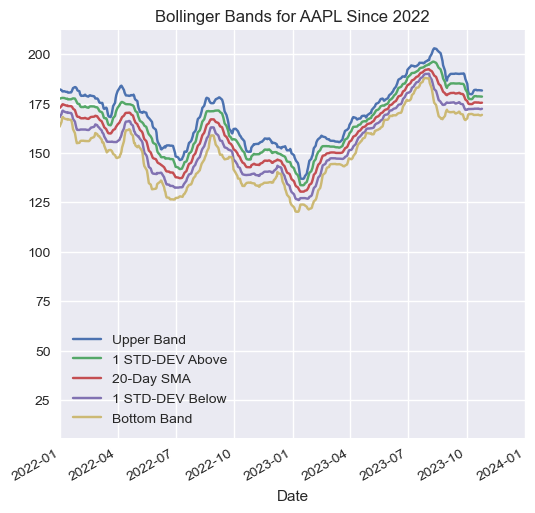

In [34]:
# Graphical Representation of Bollinger Bands for AAPL over the past 2 years

fig, ax = plt.subplots(figsize=(6,6))
df.xs("AAPL", level=1)[["upper_bollinger_band", "one_up_bollinger_band", '20_day_SMA', \
                        'lower_bollinger_band', 'lowest_bollinger_band']].plot(ax=ax)
ax.legend(labels=["Upper Band", "1 STD-DEV Above", "20-Day SMA", "1 STD-DEV Below", "Bottom Band"])
ax.set_xlim(left="2022-01-01", right="2024-01-01")
ax.set_title("Bollinger Bands for AAPL Since 2022");

### ATR - scale after splitting

Average True Range, an indicator of volatility

The true range is typically the greatest of the following three values over a defined period of time:

- The current high minus the current low.
- The absolute value of the current high minus the previous closing price.
- The absolute value of the current low minus the previous closing price.

A higher ATR value indicates greater price volatility, while a lower ATR value suggests lower volatility. Traders use ATR to determine the potential size of price moves and to set stop-loss levels and position sizes based on their risk tolerance. For example, if a stock has a high ATR, traders may use wider stop-loss orders to accommodate for larger price swings.

In predictive modeling for stock market performance, ATR can be used as a feature to assess and manage risk. It can be integrated into trading algorithms or machine learning models to adjust trading strategies based on the current market conditions. For instance, a model might incorporate ATR to dynamically set stop-loss levels or adjust the position size depending on the prevailing volatility.

In [35]:
# Function for calculating the atr, because multiple columns needed for tranformation, .transform() will not work
# because .transform can only take 1 column as an input, we  will use a groupby().apply() function

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data["High"],
                 low=stock_data["Low"],
                 close=stock_data["Close"],
                       length=14)
    return atr

In [36]:
# Need to add group_keys = False, otherwise, it will double the date index, giving us a triple index

df["ATR"] = df.groupby(level=1, group_keys=False).apply(compute_atr)

### Creating a list of unique dates in the data

In [37]:
# .index.get_level_values(0) gets the information for that level of the index

dates = df.index.get_level_values(0).unique()

In [38]:
len(dates)

2516

In [39]:
(dates == sorted(dates, reverse=False)).sum()

2516

In [40]:
# 11th date of data in our DataFrame

df.loc[dates[10]]

,Adj Close,Close,High,Low,Open,Volume,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR
Ticker,,,,,,,,,,,,,,
A,33.687004,36.695278,36.773964,36.137341,36.216022,2774331.0,-0.001872,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAL,21.937595,23.270000,23.450001,23.059999,23.250000,3508100.0,-0.001163,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAPL,16.273081,18.537500,18.631071,18.371786,18.571072,227452400.0,-0.006642,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABBV,32.244453,48.570000,48.669998,48.189999,48.230000,2282900.0,-0.062575,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABT,31.248789,37.900002,38.459999,37.680000,38.169998,6867600.0,-0.015253,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,42.840839,51.574406,52.257370,50.762043,50.984901,7108706.0,-0.011279,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZBH,79.977013,86.631065,86.951454,85.834953,85.941750,1186354.0,-0.001915,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZBRA,50.400002,50.400002,50.790001,50.150002,50.750000,196500.0,0.000062,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### MACD Indicator - scale after splitting
Moving Average Convergence Divergence
We will take the difference between the short-term EMA (Exponential Moving Average) and the long-term EMA by accessing index [0] of the resulting dataframe. 12 day and 26 day EMAs are used as the default setting for the different moving averages, hence why there are no values until after the 25th day.

In [41]:
pandas_ta.macd(close=df.xs("AAPL", level=1)["Adj Close"], length=20)[20:30]

,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
Date,,,
2013-11-25,NaN,NaN,NaN
2013-11-26,NaN,NaN,NaN
2013-11-27,NaN,NaN,NaN
2013-11-29,NaN,NaN,NaN
2013-12-02,NaN,NaN,NaN
2013-12-03,0.398296,NaN,NaN
2013-12-04,0.433908,NaN,NaN
2013-12-05,0.464117,NaN,NaN
2013-12-06,0.462789,NaN,NaN


In [42]:
# Custom function for adding a new feature, utilizing pandas_ta

def compute_MACD(close):
    macd_df = pandas_ta.macd(close=close, length=20)
    
    if macd_df is not None and not macd_df.empty:
        macd = macd_df.iloc[:, 0]
        return macd
    else:
        # This else clause was very tricky to figure out, required a series of nans in the proper length,
        # which was on occassion less than 20, therefore causing errors
        return pd.Series([np.nan] * len(close), index=close.index)

In [43]:
df["MACD"] = df.groupby(level=1, group_keys=False)["Adj Close"].apply(compute_MACD)

In [44]:
# 26th day/index[25] is the first day this statistic is available given we are using 12/26 day Exp Moving Averages

df.loc[dates[24]: dates[25]][["MACD"]]

MACD
Date       Ticker          
2013-12-02 A            NaN
           AAL          NaN
           AAPL         NaN
           ABBV         NaN
           ABT          NaN
...                     ...
2013-12-03 YUM     1.830068
           ZBH     0.730627
           ZBRA    0.897557
           ZION    0.172795
           ZTS    -0.204244

[938 rows x 1 columns]

### Dollar Volume 
Once again being treated on a per/observation basis, so the calculation is much more straight forward.

In [45]:
df["dollar_volume(M)"] = ((df['Adj Close']*df["Volume"])/1000000).round(4)

In [46]:
df.loc['2015-09-29']

,Adj Close,Close,High,Low,Open,Volume,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M)
Ticker,,,,,,,,,,,,,,,,
A,31.588047,33.740002,34.060001,33.240002,33.360001,2252400.0,-0.000854,36.288898,31.509829,32.257374,33.004920,33.752465,34.500010,0.860467,-0.787634,71.1489
AAL,37.361618,39.180000,39.770000,38.790001,39.049999,7478800.0,-0.000443,41.855946,36.765470,38.103911,39.442352,40.780793,42.119234,1.341433,-0.248827,279.4201
AAPL,24.748631,27.264999,28.377501,26.965000,28.207500,293461600.0,-0.005307,42.142548,24.524644,25.074889,25.625135,26.175381,26.725627,0.794297,-0.099089,7262.7727
ABBV,37.024635,52.790001,54.189999,51.880001,53.099998,12842800.0,-0.049280,27.173296,37.664612,39.390479,41.116346,42.842213,44.568081,2.049432,-1.899860,475.5000
ABT,33.807281,39.500000,40.150002,39.029999,39.259998,12287500.0,-0.008237,28.941480,34.191968,35.424019,36.656070,37.888121,39.120172,1.160726,-1.433813,415.4070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,47.135387,54.744789,54.931705,54.090584,54.766354,6018857.0,-0.008579,38.131942,47.184755,48.349600,49.514444,50.679289,51.844133,1.441529,-0.906050,283.7012
ZBH,85.493332,91.058250,91.495148,89.427185,89.543686,2358906.0,-0.000566,34.646127,84.939235,87.456282,89.973329,92.490376,95.007424,2.561374,-2.144589,201.6707
ZBRA,72.209999,72.209999,75.029999,71.949997,74.309998,895000.0,0.000561,31.422231,74.396039,77.597520,80.799001,84.000481,87.201962,3.231312,-3.385707,64.6279


In [47]:
df.shape

(1234259, 16)

In [48]:
df.head(2)

Adj Close      Close       High        Low      Open  \
Date       Ticker                                                         
2013-10-28 A       33.811764  36.831188  37.181686  36.566525  37.04578   
           AAL     20.749743  22.010000  22.629999  21.879999  22.24000   

                      Volume  garman_klass_vol  RSI  lowest_bollinger_band  \
Date       Ticker                                                            
2013-10-28 A       2486623.0         -0.003084  NaN                    NaN   
           AAL     4642800.0         -0.001290  NaN                    NaN   

                   lower_bollinger_band  20_day_SMA  one_up_bollinger_band  \
Date       Ticker                                                            
2013-10-28 A                        NaN         NaN                    NaN   
           AAL                      NaN         NaN                    NaN   

                   upper_bollinger_band  ATR  MACD  dollar_volume(M)  
Date       Ticker                                                     
2013-10-28 A                        NaN  NaN   NaN           84.0771  
           AAL                      NaN  NaN   NaN           96.3369

In [49]:
# Saving this form of the data for future use

# df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/S&P_data_w_technical_indicators.csv')

# NEXT

# Aggregate to monthly level and filter top 150 most liquid stocks for each month.
- We do this to reduce training time and experiment with features and strategies
- We will convert the business-daily data to month-end frequency

'D' or 'B': Daily or business day frequency.
'W': Weekly frequency, usually ending on Sundays.
'M': Monthly frequency, at the end of the month.
'Q': Quarterly frequency, at the end of each quarter (March, June, September, December).
'A' or 'Y': Annual or yearly frequency, at the end of the year.
You can also use these frequency strings with a number to specify multiples of the base frequency. For example:

'2D': Every 2 days.
'3W': Every 3 weeks.
'4M': Every 4 months.
'5A': Every 5 years.
Additionally, you can use more complex offset strings for custom resampling frequencies. For example:

'W-MON': Weekly frequency, ending on Mondays.
'Q-JAN': Quarterly frequency, ending on the last day of January.
'BQ-JAN': Business quarterly frequency, ending on the last business day of January.
You can find a more comprehensive list of offset aliases and details about custom offsets in the pandas documentation:

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

### Playing around with .resample()

In [50]:
monthly_data = df.unstack("Ticker").resample('M')

In [51]:
monthly_data = df.unstack("Ticker").resample('M')
percentage_change = monthly_data['Adj Close'].transform(lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] * 100)
percentage_change

# Every value for a given month is the same, so it is showing (month_end - month_start) / month_start * 100
# for each day within the given month

Ticker,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2013-10-28,-1.417739,-0.181747,-1.355027,-1.962755,NaN,-1.958145,0.659953,-1.103365,0.537736,3.833182,2.660639,-0.845750,...,-2.149398,-2.240653,-1.276701,-0.756530,1.575430,4.735416,19.253335,1.288207,-0.748905,0.249020,-0.664560,-0.799294
2013-10-29,-1.417739,-0.181747,-1.355027,-1.962755,NaN,-1.958145,0.659953,-1.103365,0.537736,3.833182,2.660639,-0.845750,...,-2.149398,-2.240653,-1.276701,-0.756530,1.575430,4.735416,19.253335,1.288207,-0.748905,0.249020,-0.664560,-0.799294
2013-10-30,-1.417739,-0.181747,-1.355027,-1.962755,NaN,-1.958145,0.659953,-1.103365,0.537736,3.833182,2.660639,-0.845750,...,-2.149398,-2.240653,-1.276701,-0.756530,1.575430,4.735416,19.253335,1.288207,-0.748905,0.249020,-0.664560,-0.799294
2013-10-31,-1.417739,-0.181747,-1.355027,-1.962755,NaN,-1.958145,0.659953,-1.103365,0.537736,3.833182,2.660639,-0.845750,...,-2.149398,-2.240653,-1.276701,-0.756530,1.575430,4.735416,19.253335,1.288207,-0.748905,0.249020,-0.664560,-0.799294
2013-11-01,4.833707,4.634584,7.554665,-1.041691,NaN,3.327922,1.887770,6.123280,3.973628,-2.938815,-1.132586,6.254101,...,-0.289457,-0.692152,1.333457,-3.112044,4.782961,0.869595,4.033701,13.434611,4.004966,7.373657,3.348528,-2.167077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-19,-6.762849,-13.411765,-1.525176,-1.036112,-13.224955,-1.715270,5.190872,-4.660394,0.001921,-8.915237,-4.245275,-8.789737,...,-0.192175,-4.569710,-3.983585,8.068331,-6.088386,-5.831851,-4.421692,-3.798177,-6.982587,-14.861105,-11.525836,-5.245179
2023-10-20,-6.762849,-13.411765,-1.525176,-1.036112,-13.224955,-1.715270,5.190872,-4.660394,0.001921,-8.915237,-4.245275,-8.789737,...,-0.192175,-4.569710,-3.983585,8.068331,-6.088386,-5.831851,-4.421692,-3.798177,-6.982587,-14.861105,-11.525836,-5.245179
2023-10-23,-6.762849,-13.411765,-1.525176,-1.036112,-13.224955,-1.715270,5.190872,-4.660394,0.001921,-8.915237,-4.245275,-8.789737,...,-0.192175,-4.569710,-3.983585,8.068331,-6.088386,-5.831851,-4.421692,-3.798177,-6.982587,-14.861105,-11.525836,-5.245179


In [52]:
pd.set_option("display.max_rows", 25)
monthly_data['Adj Close']["AAPL"].mean()

Date
2013-10-31     16.318573
2013-11-30     16.433293
2013-12-31     17.546197
2014-01-31     16.849817
2014-02-28     16.592938
                 ...    
2023-06-30    184.034816
2023-07-31    192.152022
2023-08-31    180.997362
2023-09-30    177.002501
2023-10-31    175.918891
Freq: M, Name: AAPL, Length: 121, dtype: float64

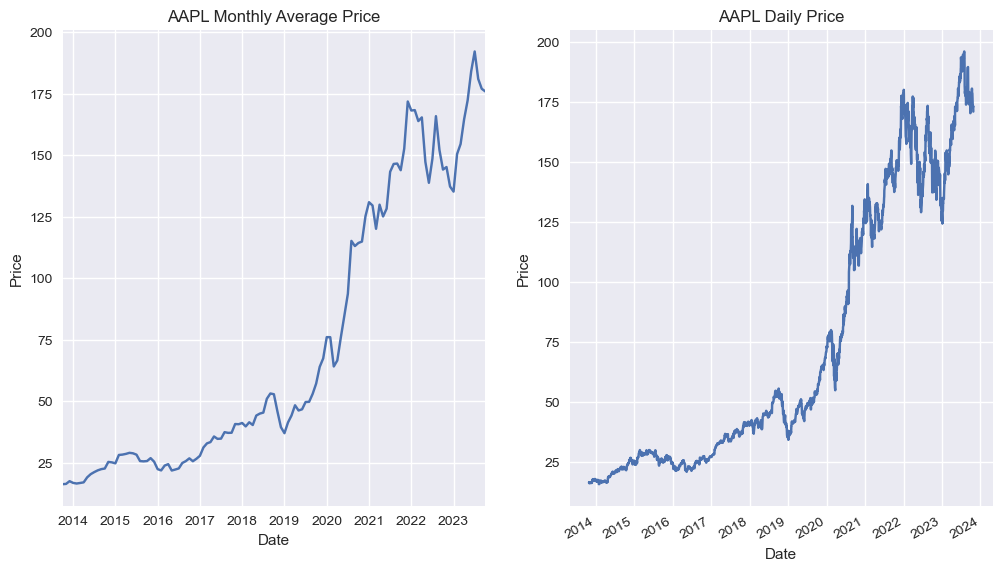

In [53]:
# Plotting the average price of AAPL over the range of dates in our data

fig, ax = plt.subplots(ncols=2, figsize=(12,7))
plt.style.use('seaborn')

# Using monthly data for the averaged data
monthly_data['Adj Close']["AAPL"].mean().plot(kind='line', ax=ax[0])
ax[0].set_title('AAPL Monthly Average Price')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Price')

# Using df for daily data
df.xs("AAPL", level=1)["Adj Close"].plot(kind='line', ax=ax[1]);
ax[1].set_title('AAPL Daily Price')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Price')

plt.grid(True)
plt.show()

In [54]:
# Data for 121 months of trading, resample('M') aggregates data in end-of-month intervals
# The resample() function is used to change the frequency of the time series data,  'M' stands for monthly 
# which means that we are resampling the data at a monthly frequency, doesn't appear to be case sensitive

df.unstack("Ticker")["dollar_volume(M)"].resample('M').mean()

Ticker,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2013-10-31,73.233825,155.738375,7404.227900,156.259100,NaN,176.736250,30.485725,175.863700,212.535825,80.720275,191.897750,124.255200,...,44.453625,95.459325,135.821425,60.266400,779.847850,45.616100,108.531100,149.169675,104.390475,11.256625,42.943875,113.021750
2013-11-30,126.915295,271.937775,4304.568995,142.161005,NaN,192.501145,15.033025,197.035975,190.341910,90.502850,167.248460,123.636235,...,25.299465,72.639765,172.631265,67.791850,765.248960,27.771810,38.932080,218.011325,95.082590,11.207155,39.248490,114.922305
2013-12-31,103.210810,360.389262,5893.826881,235.608914,NaN,175.364167,18.402033,233.961371,249.097357,72.258914,137.789695,119.727752,...,19.949857,77.712271,194.175290,84.769895,817.927305,44.592276,30.593762,154.708100,78.301429,10.569205,48.701943,92.566733
2014-01-31,135.350481,390.486162,6969.958376,257.647319,NaN,252.345005,30.469762,232.093605,192.653095,85.860190,157.532510,108.398862,...,22.329943,67.082262,328.494000,60.880048,783.633776,45.635371,37.829190,224.837510,105.311162,9.598205,55.799252,107.458081
2014-02-28,196.379868,344.713853,5126.894242,211.700342,NaN,277.203474,23.745032,170.137368,268.645637,92.288668,159.687511,137.767489,...,26.590684,69.858011,340.409468,50.094816,816.085979,52.354500,45.724295,216.327705,100.331953,24.410968,52.551226,184.421205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,288.062400,355.253881,11356.804776,856.896757,705.352605,537.479662,133.079924,910.620829,2429.608200,683.738962,206.856048,356.045095,...,135.245548,145.642786,216.775448,266.371948,1605.263686,67.840986,194.961676,268.237076,197.734638,103.578690,121.983671,341.883286
2023-07-31,235.603670,435.490255,9569.413875,833.236260,745.702240,530.104790,195.153490,574.704425,1576.618650,614.870395,230.228330,436.472805,...,157.584475,113.770955,187.956790,236.678460,1807.871770,59.801945,125.841465,185.124015,159.511985,101.127735,158.312510,356.143030
2023-08-31,224.004496,345.748587,10398.352552,576.661717,633.134435,438.548191,118.491391,488.369217,1171.830148,616.767157,198.657809,317.371283,...,148.162978,93.844596,212.036196,234.353243,1486.405109,49.508826,141.903013,192.522878,223.183970,147.578109,85.567270,326.408587


In [55]:
# Re-stacking the data so that every month is a primary index, and every ticker is a secondary index

df.unstack("Ticker")["dollar_volume(M)"].resample('M').mean().stack("Ticker").to_frame('dollar_volume')

dollar_volume
Date       Ticker               
2013-10-31 A           73.233825
           AAL        155.738375
           AAPL      7404.227900
           ABBV       156.259100
           ABT        176.736250
...                          ...
2023-10-31 YUM        195.516933
           ZBH        174.486233
           ZBRA        98.651750
           ZION       121.374122
           ZTS        247.934272

[59355 rows x 1 columns]

In [56]:
# we are creating a list of columns to be used as features in our modeling, and removing the features that will not 
# be relevant for our models

last_cols = [c for c in df.columns.unique() if c not in ['Close', "High", 'Low', 'Open', 'Volume',\
                                                         'dollar_volume(M)']]

In [57]:
df.unstack()[last_cols].resample("M").last().stack('Ticker')

Adj Close  garman_klass_vol        RSI  \
Date       Ticker                                            
2013-10-31 A        33.332401         -0.003205        NaN   
           AAL      20.712030         -0.002151        NaN   
           AAPL     16.292391         -0.007555        NaN   
           ABBV     32.164795         -0.066270        NaN   
           ABT      30.135710         -0.016181        NaN   
...                       ...               ...        ...   
2023-10-31 YUM     120.309998          0.000098  43.055362   
           ZBH     103.639999          0.000068  33.161445   
           ZBRA    198.910004          0.000798  28.572239   
           ZION     29.629999          0.000654  36.867183   
           ZTS     163.669998          0.000195  32.323070   

                   lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Date       Ticker                                                            
2013-10-31 A                         NaN                   NaN         NaN   
           AAL                       NaN                   NaN         NaN   
           AAPL                      NaN                   NaN         NaN   
           ABBV                      NaN                   NaN         NaN   
           ABT                       NaN                   NaN         NaN   
...                                  ...                   ...         ...   
2023-10-31 YUM                115.674147            118.113573  120.552999   
           ZBH                101.119224            104.369862  107.620501   
           ZBRA               194.638472            206.127986  217.617500   
           ZION                29.283997             31.398749   33.513500   
           ZTS                164.570025            168.207262  171.844498   

                   one_up_bollinger_band  upper_bollinger_band       ATR  \
Date       Ticker                                                          
2013-10-31 A                         NaN                   NaN       NaN   
           AAL                       NaN                   NaN       NaN   
           AAPL                      NaN                   NaN       NaN   
           ABBV                      NaN                   NaN       NaN   
           ABT                       NaN                   NaN       NaN   
...                                  ...                   ...       ...   
2023-10-31 YUM                122.992426            125.431852  2.023279   
           ZBH                110.871139            114.121777  2.576994   
           ZBRA               229.107014            240.596528  6.741924   
           ZION                35.628251             37.743003  1.491345   
           ZTS                175.481735            179.118972  3.378822   

                        MACD  
Date       Ticker             
2013-10-31 A             NaN  
           AAL           NaN  
           AAPL          NaN  
           ABBV          NaN  
           ABT           NaN  
...                      ...  
2023-10-31 YUM     -1.650241  
           ZBH     -3.299960  
           ZBRA   -11.018856  
           ZION    -1.095245  
           ZTS     -3.473640  

[59355 rows x 10 columns]

In [58]:
# This is a DF object for the end of month data for each of the stocks in the data, so roughly 121 * 503

data = pd.concat([df.unstack("Ticker")["dollar_volume(M)"].resample('M').mean().stack("Ticker").to_frame('dollar_volume'),\
          df.unstack()[last_cols].resample("M").last().stack('Ticker')], axis=1)

In [59]:
# A little bit smaller than 121 * 503 because not all current S&P stocks were active for the full range of time

data.shape

(59355, 11)

In [60]:
data.isna().sum()

dollar_volume              0
Adj Close                  0
garman_klass_vol           0
RSI                      501
lowest_bollinger_band    498
lower_bollinger_band     498
20_day_SMA               498
one_up_bollinger_band    498
upper_bollinger_band     498
ATR                      491
MACD                     976
dtype: int64

### Dropna()
I do think that given the size of the data and the requirements for modeling, that it is more useful to drop these null values as opposed to imputing them with some stock strategy.

In [61]:
data.dropna(inplace=True)
data.shape

(58379, 11)

In [62]:
f"We lost about {59355-58379} rows of data."

'We lost about 976 rows of data.'

All of the rows of data seemed to be encompassed by the missing MACD values which makes sense as that was the field that required the greatest amount of time to be confirmed.

### Calculate the 5-year rolling avg of dollar volume for each stock before filtering by liquidity

# In this case, we have already resampled our data on a monthly basis, so using 5*12 means 5 years
The .rolling() method in pandas is used for creating rolling views of data in a pandas DataFrame or Series. A rolling view allows you to perform window-based calculations on your data, which is often useful in time series analysis, signal processing, and other data analysis tasks. This method is particularly helpful for calculating moving averages and other rolling statistics.

In [63]:
# .rolling(), captures specifed number of observations as a subset and can be used to calculate agg functions


# Had to come back and add the ".loc[:]" part, before was data['dollar_volume'], also added the min_periods argument
data['5yr_rolling_avg'] = data.loc[:, "dollar_volume"].unstack("Ticker").rolling(5*12, min_periods=12).mean().stack()

In [64]:
data

dollar_volume   Adj Close  garman_klass_vol        RSI  \
Date       Ticker                                                           
2013-12-31 A          103.210810   37.641235         -0.002942  65.281944   
           AAL        360.389262   23.804222         -0.000265  55.237133   
           AAPL      5893.826881   17.588915         -0.005293  56.934098   
           ABBV       235.608914   35.059299         -0.065822  60.318635   
           ABT        175.364167   31.603342         -0.014538  56.962503   
...                          ...         ...               ...        ...   
2023-10-31 YUM        195.516933  120.309998          0.000098  43.055362   
           ZBH        174.486233  103.639999          0.000068  33.161445   
           ZBRA        98.651750  198.910004          0.000798  28.572239   
           ZION       121.374122   29.629999          0.000654  36.867183   
           ZTS        247.934272  163.669998          0.000195  32.323070   

                   lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Date       Ticker                                                            
2013-12-31 A                   34.750014             35.739432   36.728850   
           AAL                 20.794745             22.210630   23.626515   
           AAPL                17.134581             17.346994   17.559407   
           ABBV                33.053989             33.860298   34.666608   
           ABT                 29.704859             30.316253   30.927648   
...                                  ...                   ...         ...   
2023-10-31 YUM                115.674147            118.113573  120.552999   
           ZBH                101.119224            104.369862  107.620501   
           ZBRA               194.638472            206.127986  217.617500   
           ZION                29.283997             31.398749   33.513500   
           ZTS                164.570025            168.207262  171.844498   

                   one_up_bollinger_band  upper_bollinger_band       ATR  \
Date       Ticker                                                          
2013-12-31 A                   37.718268             38.707686  0.589630   
           AAL                 25.042400             26.458285  0.796008   
           AAPL                17.771820             17.984233  0.314953   
           ABBV                35.472917             36.279226  1.061766   
           ABT                 31.539043             32.150437  0.495434   
...                                  ...                   ...       ...   
2023-10-31 YUM                122.992426            125.431852  2.023279   
           ZBH                110.871139            114.121777  2.576994   
           ZBRA               229.107014            240.596528  6.741924   
           ZION                35.628251             37.743003  1.491345   
           ZTS                175.481735            179.118972  3.378822   

                        MACD  5yr_rolling_avg  
Date       Ticker                              
2013-12-31 A        0.808867              NaN  
           AAL      0.488108              NaN  
           AAPL     0.212293              NaN  
           ABBV     0.615362              NaN  
           ABT      0.202480              NaN  
...                      ...              ...  
2023-10-31 YUM     -1.650241       188.101241  
           ZBH     -3.299960       171.486022  
           ZBRA   -11.018856       124.404860  
           ZION    -1.095245        89.392853  
           ZTS     -3.473640       298.817025  

[58379 rows x 12 columns]

In [65]:
data['dollar_vol_rank'] = data.groupby("Date")["5yr_rolling_avg"].rank(ascending=False)

In [66]:
data

dollar_volume   Adj Close  garman_klass_vol        RSI  \
Date       Ticker                                                           
2013-12-31 A          103.210810   37.641235         -0.002942  65.281944   
           AAL        360.389262   23.804222         -0.000265  55.237133   
           AAPL      5893.826881   17.588915         -0.005293  56.934098   
           ABBV       235.608914   35.059299         -0.065822  60.318635   
           ABT        175.364167   31.603342         -0.014538  56.962503   
...                          ...         ...               ...        ...   
2023-10-31 YUM        195.516933  120.309998          0.000098  43.055362   
           ZBH        174.486233  103.639999          0.000068  33.161445   
           ZBRA        98.651750  198.910004          0.000798  28.572239   
           ZION       121.374122   29.629999          0.000654  36.867183   
           ZTS        247.934272  163.669998          0.000195  32.323070   

                   lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Date       Ticker                                                            
2013-12-31 A                   34.750014             35.739432   36.728850   
           AAL                 20.794745             22.210630   23.626515   
           AAPL                17.134581             17.346994   17.559407   
           ABBV                33.053989             33.860298   34.666608   
           ABT                 29.704859             30.316253   30.927648   
...                                  ...                   ...         ...   
2023-10-31 YUM                115.674147            118.113573  120.552999   
           ZBH                101.119224            104.369862  107.620501   
           ZBRA               194.638472            206.127986  217.617500   
           ZION                29.283997             31.398749   33.513500   
           ZTS                164.570025            168.207262  171.844498   

                   one_up_bollinger_band  upper_bollinger_band       ATR  \
Date       Ticker                                                          
2013-12-31 A                   37.718268             38.707686  0.589630   
           AAL                 25.042400             26.458285  0.796008   
           AAPL                17.771820             17.984233  0.314953   
           ABBV                35.472917             36.279226  1.061766   
           ABT                 31.539043             32.150437  0.495434   
...                                  ...                   ...       ...   
2023-10-31 YUM                122.992426            125.431852  2.023279   
           ZBH                110.871139            114.121777  2.576994   
           ZBRA               229.107014            240.596528  6.741924   
           ZION                35.628251             37.743003  1.491345   
           ZTS                175.481735            179.118972  3.378822   

                        MACD  5yr_rolling_avg  dollar_vol_rank  
Date       Ticker                                               
2013-12-31 A        0.808867              NaN              NaN  
           AAL      0.488108              NaN              NaN  
           AAPL     0.212293              NaN              NaN  
           ABBV     0.615362              NaN              NaN  
           ABT      0.202480              NaN              NaN  
...                      ...              ...              ...  
2023-10-31 YUM     -1.650241       188.101241            255.0  
           ZBH     -3.299960       171.486022            281.0  
           ZBRA   -11.018856       124.404860            358.0  
           ZION    -1.095245        89.392853            444.0  
           ZTS     -3.473640       298.817025            154.0  

[58379 rows x 13 columns]

In [67]:
data["dollar_vol_rank"].min()

1.0

In [68]:
# selecting the top 150 liquid stocks of each month

data[data["dollar_vol_rank"] <= 150]

dollar_volume   Adj Close  garman_klass_vol        RSI  \
Date       Ticker                                                           
2014-11-30 AAL        489.874263   45.982338          0.001106  71.781405   
           AAPL      4393.463679   26.649851         -0.004808  75.927592   
           ABBV       283.934111   47.424049         -0.054280  72.710752   
           ABT        155.191000   37.520535         -0.011064  60.929532   
           ACN        166.421537   74.361420         -0.007148  71.142317   
...                          ...         ...               ...        ...   
2023-10-31 VRTX       442.488256  363.040009          0.000200  53.833235   
           VZ         829.951094   33.689999          0.000221  58.946533   
           WFC        638.798072   39.029999          0.000131  39.236461   
           WMT        847.706667  162.759995          0.000062  55.397237   
           XOM       2504.217889  108.589996          0.000079  44.793090   

                   lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Date       Ticker                                                            
2014-11-30 AAL                 38.748957             40.092589   41.436220   
           AAPL                23.525069             24.414897   25.304726   
           ABBV                41.462112             42.970156   44.478201   
           ABT                 36.375565             36.687783   37.000000   
           ACN                 69.766233             70.965151   72.164068   
...                                  ...                   ...         ...   
2023-10-31 VRTX               344.018442            352.603220  361.187999   
           VZ                  29.828625             30.701467   31.574308   
           WFC                 38.205341             39.160670   40.116000   
           WMT                156.054002            158.010000  159.965999   
           XOM                104.273387            107.766443  111.259499   

                   one_up_bollinger_band  upper_bollinger_band       ATR  \
Date       Ticker                                                          
2014-11-30 AAL                 42.779851             44.123482  1.657980   
           AAPL                26.194555             27.084384  0.470102   
           ABBV                45.986245             47.494290  1.261716   
           ABT                 37.312218             37.624436  0.627243   
           ACN                 73.362986             74.561903  0.952772   
...                                  ...                   ...       ...   
2023-10-31 VRTX               369.772778            378.357556  6.590981   
           VZ                  32.447150             33.319992  0.808540   
           WFC                 41.071329             42.026659  0.928127   
           WMT                161.921997            163.877996  2.215188   
           XOM                114.752555            118.245611  2.497244   

                       MACD  5yr_rolling_avg  dollar_vol_rank  
Date       Ticker                                              
2014-11-30 AAL     1.776186       424.796771             41.0  
           AAPL    0.865696      5117.260814              1.0  
           ABBV    1.669114       329.900460             55.0  
           ABT     0.383073       201.862310            110.0  
           ACN     1.289446       194.229076            115.0  
...                     ...              ...              ...  
2023-10-31 VRTX    4.149759       376.751542            119.0  
           VZ      0.107031       802.525189             43.0  
           WFC    -0.411437      1012.550657             33.0  
           WMT     0.245920       956.944630             34.0  
           XOM    -1.027632      1366.335094             17.0  

[16200 rows x 13 columns]

In [69]:
# Removing unneccesary features for modeling

top_150_df = data[data["dollar_vol_rank"] <= 150].drop(columns=["dollar_volume", "dollar_vol_rank", "5yr_rolling_avg"])

In [70]:
top_150_df

Adj Close  garman_klass_vol        RSI  \
Date       Ticker                                            
2014-11-30 AAL      45.982338          0.001106  71.781405   
           AAPL     26.649851         -0.004808  75.927592   
           ABBV     47.424049         -0.054280  72.710752   
           ABT      37.520535         -0.011064  60.929532   
           ACN      74.361420         -0.007148  71.142317   
...                       ...               ...        ...   
2023-10-31 VRTX    363.040009          0.000200  53.833235   
           VZ       33.689999          0.000221  58.946533   
           WFC      39.029999          0.000131  39.236461   
           WMT     162.759995          0.000062  55.397237   
           XOM     108.589996          0.000079  44.793090   

                   lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Date       Ticker                                                            
2014-11-30 AAL                 38.748957             40.092589   41.436220   
           AAPL                23.525069             24.414897   25.304726   
           ABBV                41.462112             42.970156   44.478201   
           ABT                 36.375565             36.687783   37.000000   
           ACN                 69.766233             70.965151   72.164068   
...                                  ...                   ...         ...   
2023-10-31 VRTX               344.018442            352.603220  361.187999   
           VZ                  29.828625             30.701467   31.574308   
           WFC                 38.205341             39.160670   40.116000   
           WMT                156.054002            158.010000  159.965999   
           XOM                104.273387            107.766443  111.259499   

                   one_up_bollinger_band  upper_bollinger_band       ATR  \
Date       Ticker                                                          
2014-11-30 AAL                 42.779851             44.123482  1.657980   
           AAPL                26.194555             27.084384  0.470102   
           ABBV                45.986245             47.494290  1.261716   
           ABT                 37.312218             37.624436  0.627243   
           ACN                 73.362986             74.561903  0.952772   
...                                  ...                   ...       ...   
2023-10-31 VRTX               369.772778            378.357556  6.590981   
           VZ                  32.447150             33.319992  0.808540   
           WFC                 41.071329             42.026659  0.928127   
           WMT                161.921997            163.877996  2.215188   
           XOM                114.752555            118.245611  2.497244   

                       MACD  
Date       Ticker            
2014-11-30 AAL     1.776186  
           AAPL    0.865696  
           ABBV    1.669114  
           ABT     0.383073  
           ACN     1.289446  
...                     ...  
2023-10-31 VRTX    4.149759  
           VZ      0.107031  
           WFC    -0.411437  
           WMT     0.245920  
           XOM    -1.027632  

[16200 rows x 10 columns]

In [71]:
top_150_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 16200 entries, (Timestamp('2014-11-30 00:00:00'), 'AAL') to (Timestamp('2023-10-31 00:00:00'), 'XOM')
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Adj Close              16200 non-null  float64
 1   garman_klass_vol       16200 non-null  float64
 2   RSI                    16200 non-null  float64
 3   lowest_bollinger_band  16200 non-null  float64
 4   lower_bollinger_band   16200 non-null  float64
 5   20_day_SMA             16200 non-null  float64
 6   one_up_bollinger_band  16200 non-null  float64
 7   upper_bollinger_band   16200 non-null  float64
 8   ATR                    16200 non-null  float64
 9   MACD                   16200 non-null  float64
dtypes: float64(10)
memory usage: 1.3+ MB


In [72]:
top_150_df.isna().sum()

Adj Close                0
garman_klass_vol         0
RSI                      0
lowest_bollinger_band    0
lower_bollinger_band     0
20_day_SMA               0
one_up_bollinger_band    0
upper_bollinger_band     0
ATR                      0
MACD                     0
dtype: int64

In [73]:
top_150_df.index.min()

(Timestamp('2014-11-30 00:00:00'), 'AAL')

### Periodic Recap
All of the steps that we have taken so far have been to filter out the top 150 most liquid stocks over a monthly period. Whereas we used to have data going back to 2013, we now only have data going back to 2018 do to the requirements of using a 5 year rolling average of monthly volume. This gives us a good set of data to attempt to predict as it is data comprised of frequently traded stocks.

# Calculate Monthly Returns for different time horizons as features

To capture time series dynamics that reflect momentum patterns, we compute historical returns using the method .pct_change)lag), that produces returns over various periods as defined by the "lags".

In [74]:
def calculate_return(df):

    lags = [1, 2, 3, 6, 9, 12]

    # we want to clip values above outlier threshold
    outlier_cutoff = 0.005

    # This code applies lags of "lags" months, .pipe() allows you to string multiple operations together in a 
    # concise way, as opposed to using multiple lines of code
    for lag in lags:
        df[f'return_{lag}m'] = (df["Adj Close"].pct_change(lag).pipe(lambda x: x.clip(\
                                            lower=x.quantile(outlier_cutoff), upper=x.quantile(1-outlier_cutoff))).\
                                            add(1).pow(1/lag)).sub(1)
    
    return df

# This function/setup can be useful later in other scenarios I believe
This function is particularly useful because the observations have already been converted to monthly observations, so moving dates forward in increments of "1 month" no longer run the risk of running into holidays or weekends.

In [75]:
# Adding returns for these various periods of time

top150 = top_150_df.groupby(level=1, group_keys=False).apply(calculate_return).copy()

# New DF object with returns for various periods

In [76]:
top150

Adj Close  garman_klass_vol        RSI  \
Date       Ticker                                            
2014-11-30 AAL      45.982338          0.001106  71.781405   
           AAPL     26.649851         -0.004808  75.927592   
           ABBV     47.424049         -0.054280  72.710752   
           ABT      37.520535         -0.011064  60.929532   
           ACN      74.361420         -0.007148  71.142317   
...                       ...               ...        ...   
2023-10-31 VRTX    363.040009          0.000200  53.833235   
           VZ       33.689999          0.000221  58.946533   
           WFC      39.029999          0.000131  39.236461   
           WMT     162.759995          0.000062  55.397237   
           XOM     108.589996          0.000079  44.793090   

                   lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Date       Ticker                                                            
2014-11-30 AAL                 38.748957             40.092589   41.436220   
           AAPL                23.525069             24.414897   25.304726   
           ABBV                41.462112             42.970156   44.478201   
           ABT                 36.375565             36.687783   37.000000   
           ACN                 69.766233             70.965151   72.164068   
...                                  ...                   ...         ...   
2023-10-31 VRTX               344.018442            352.603220  361.187999   
           VZ                  29.828625             30.701467   31.574308   
           WFC                 38.205341             39.160670   40.116000   
           WMT                156.054002            158.010000  159.965999   
           XOM                104.273387            107.766443  111.259499   

                   one_up_bollinger_band  upper_bollinger_band       ATR  \
Date       Ticker                                                          
2014-11-30 AAL                 42.779851             44.123482  1.657980   
           AAPL                26.194555             27.084384  0.470102   
           ABBV                45.986245             47.494290  1.261716   
           ABT                 37.312218             37.624436  0.627243   
           ACN                 73.362986             74.561903  0.952772   
...                                  ...                   ...       ...   
2023-10-31 VRTX               369.772778            378.357556  6.590981   
           VZ                  32.447150             33.319992  0.808540   
           WFC                 41.071329             42.026659  0.928127   
           WMT                161.921997            163.877996  2.215188   
           XOM                114.752555            118.245611  2.497244   

                       MACD  return_1m  return_2m  return_3m  return_6m  \
Date       Ticker                                                         
2014-11-30 AAL     1.776186        NaN        NaN        NaN        NaN   
           AAPL    0.865696        NaN        NaN        NaN        NaN   
           ABBV    1.669114        NaN        NaN        NaN        NaN   
           ABT     0.383073        NaN        NaN        NaN        NaN   
           ACN     1.289446        NaN        NaN        NaN        NaN   
...                     ...        ...        ...        ...        ...   
2023-10-31 VRTX    4.149759   0.043998   0.020882   0.010022   0.010627   
           VZ      0.107031   0.061682  -0.008194   0.003209  -0.017041   
           WFC    -0.411437  -0.044787  -0.027753  -0.051934  -0.000449   
           WMT     0.245920   0.017695   0.000461   0.007201   0.013851   
           XOM    -1.027632  -0.076459  -0.011761   0.006915  -0.011464   

                   return_9m  return_12m  
Date       Ticker                         
2014-11-30 AAL           NaN         NaN  
           AAPL          NaN         NaN  
           ABBV          NaN         NaN  
           ABT    

In [77]:
# This is an example cell to show the process of the custom function "calculate_return(df)"


# Create a DataFrame with date and closing prices
data44 = {'Date': pd.date_range(start='2023-01-01', periods=10, freq='D'),
        'Closing Price': [100, 105, 110, 115, 120, 125, 130, 135, 140, 145]}
hypothetical_df = pd.DataFrame(data44)
hypothetical_df.set_index('Date', inplace=True)

# Calculate returns over different lag periods
lags = [1, 2, 3]
outlier_cutoff = 0.05  # For clipping outliers

for lag in lags:
    # Calculate percentage change over the specified lag
    returns = hypothetical_df['Closing Price'].pct_change(lag)

    # Clip outliers
    lower = returns.quantile(outlier_cutoff)
    upper = returns.quantile(1 - outlier_cutoff)
    returns = returns.clip(lower=lower, upper=upper)

    # Add 1 and undo compounding
    returns = returns.add(1).pow(1 / lag)

    # Add the returns to the DataFrame for the given lag
    hypothetical_df[f'Return_{lag}d'] = returns

hypothetical_df

,Closing Price,Return_1d,Return_2d,Return_3d
Date,,,,
2023-01-01,100,NaN,NaN,NaN
2023-01-02,105,1.049048,NaN,NaN
2023-01-03,110,1.047619,1.048014,NaN
2023-01-04,115,1.045455,1.046536,1.047038
2023-01-05,120,1.043478,1.044466,1.045516
2023-01-06,125,1.041667,1.042572,1.043532
2023-01-07,130,1.040000,1.040833,1.041714
2023-01-08,135,1.038462,1.039230,1.040042
2023-01-09,140,1.037037,1.037749,1.038499


# NEXT

# Downloading Fama-French Factors and Calculate Rolling Factor Betas

- Fama-French data to estimate the exposure of assets to common risk factors using linear regression
- the five F.F. factors are:
    -- market risk
    -- size
    -- value
    -- operating profitability
    -- investment
Each factor has been shown to explain returns and are commonly used to assess the risk/return profile of portfolios. 
We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression

In [78]:
# Also the data, but without the time stamps

# ff = pd.read_csv("/Users/samalainabayeva/Desktop/Capstone Project/F-F_Research_Data_5_Factors_2x3.csv", skiprows=2)

In [79]:
ff=0

Statsmodels documentation leads to this source as well.(https://www.statsmodels.org/dev/examples/notebooks/generated/rolling_ls.html)

In [80]:
# web.DataReader() often used to access financial data online
# requires: name("F-F_Res..."), data source('famafrench'), start(2010), end(optional), pause/session/api_key

# Dictionary with 2 keys -> each a pandas dataframe -> 0 for monthly data, 1 for yearly data, we want 0
web.DataReader("F-F_Research_Data_5_Factors_2x3", 'famafrench', start='2010')

{0:          Mkt-RF   SMB   HML   RMW   CMA    RF
 Date                                         
 2010-01   -3.36  0.34  0.43 -1.27  0.46  0.00
 2010-02    3.40  1.51  3.23 -0.27  1.43  0.00
 2010-03    6.31  1.85  2.21 -0.65  1.69  0.01
 2010-04    2.00  4.98  2.89  0.69  1.72  0.01
 2010-05   -7.89  0.04 -2.44  1.30 -0.21  0.01
 ...         ...   ...   ...   ...   ...   ...
 2023-03    2.51 -6.94 -8.85  2.24 -2.37  0.36
 2023-04    0.61 -2.56 -0.04  2.42  2.86  0.35
 2023-05    0.35 -0.38 -7.72 -1.81 -7.22  0.36
 2023-06    6.46  1.34 -0.26  2.18 -1.62  0.40
 2023-07    3.21  2.86  4.13 -0.56  0.62  0.45
 
 [163 rows x 6 columns],
 1:       Mkt-RF    SMB    HML    RMW    CMA    RF
 Date                                          
 2010   17.37  13.61  -5.17  -1.54   9.78  0.12
 2011    0.44  -5.50  -8.41  13.48  -1.16  0.04
 2012   16.27  -0.52   9.99  -5.35   9.37  0.06
 2013   35.20   8.33   2.60  -4.17   0.95  0.02
 2014   11.71  -7.91  -1.45   1.28  -1.46  0.02
 2015    0.09  -5.89

In [81]:
web.DataReader("F-F_Research_Data_5_Factors_2x3", 'famafrench', start='2010')[0]

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2010-01,-3.36,0.34,0.43,-1.27,0.46,0.00
2010-02,3.40,1.51,3.23,-0.27,1.43,0.00
2010-03,6.31,1.85,2.21,-0.65,1.69,0.01
2010-04,2.00,4.98,2.89,0.69,1.72,0.01
2010-05,-7.89,0.04,-2.44,1.30,-0.21,0.01
...,...,...,...,...,...,...
2023-03,2.51,-6.94,-8.85,2.24,-2.37,0.36
2023-04,0.61,-2.56,-0.04,2.42,2.86,0.35
2023-05,0.35,-0.38,-7.72,-1.81,-7.22,0.36


In [82]:
type(web.DataReader("F-F_Research_Data_5_Factors_2x3", 'famafrench', start='2010')[0])
factor_data = web.DataReader("F-F_Research_Data_5_Factors_2x3", 'famafrench', start='2010')[0].drop("RF", axis=1)

In [83]:
# Weird data type

type(factor_data.index[0])

pandas._libs.tslibs.period.Period

In [84]:
# Converting to a date time object

factor_data.index = factor_data.index.to_timestamp()

In [85]:
factor_data.index

DatetimeIndex(['2010-01-01', '2010-02-01', '2010-03-01', '2010-04-01',
               '2010-05-01', '2010-06-01', '2010-07-01', '2010-08-01',
               '2010-09-01', '2010-10-01',
               ...
               '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01',
               '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01',
               '2023-06-01', '2023-07-01'],
              dtype='datetime64[ns]', name='Date', length=163, freq='MS')

In [86]:
top150.head(1)

,,Adj Close,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
Date,Ticker,,,,,,,,,,,,,,,,
2014-11-30,AAL,45.982338,0.001106,71.781405,38.748957,40.092589,41.43622,42.779851,44.123482,1.65798,1.776186,NaN,NaN,NaN,NaN,NaN,NaN


The timestamp for the FF is for the beginning of every month, whereas our pandas dataframe with stock info is indexed to the end of every month. We need to correct that, and also correct the representation of the FF's, which need to be converted from %'s to decimals.

In [87]:
# Resample "MS" gets the defaults to the first, this data might be weird given that it is monthly data without
# any interpolated data points

factor_data = factor_data.resample("M").last().div(100)

In [88]:
factor_data

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2010-01-31,-0.0336,0.0034,0.0043,-0.0127,0.0046
2010-02-28,0.0340,0.0151,0.0323,-0.0027,0.0143
2010-03-31,0.0631,0.0185,0.0221,-0.0065,0.0169
2010-04-30,0.0200,0.0498,0.0289,0.0069,0.0172
2010-05-31,-0.0789,0.0004,-0.0244,0.0130,-0.0021
...,...,...,...,...,...
2023-03-31,0.0251,-0.0694,-0.0885,0.0224,-0.0237
2023-04-30,0.0061,-0.0256,-0.0004,0.0242,0.0286
2023-05-31,0.0035,-0.0038,-0.0772,-0.0181,-0.0722


### Join this data with our monthly stock data

In [89]:
top150.head(2)

Adj Close  garman_klass_vol        RSI  \
Date       Ticker                                           
2014-11-30 AAL     45.982338          0.001106  71.781405   
           AAPL    26.649851         -0.004808  75.927592   

                   lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Date       Ticker                                                            
2014-11-30 AAL                 38.748957             40.092589   41.436220   
           AAPL                23.525069             24.414897   25.304726   

                   one_up_bollinger_band  upper_bollinger_band       ATR  \
Date       Ticker                                                          
2014-11-30 AAL                 42.779851             44.123482  1.657980   
           AAPL                26.194555             27.084384  0.470102   

                       MACD  return_1m  return_2m  return_3m  return_6m  \
Date       Ticker                                                         
2014-11-30 AAL     1.776186        NaN        NaN        NaN        NaN   
           AAPL    0.865696        NaN        NaN        NaN        NaN   

                   return_9m  return_12m  
Date       Ticker                         
2014-11-30 AAL           NaN         NaN  
           AAPL          NaN         NaN

In [90]:
top150.loc["2017-10-31"]

,Adj Close,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
Ticker,,,,,,,,,,,,,,,,
AAL,45.534164,-0.000363,41.051761,45.924538,47.723053,49.521568,51.320083,53.118598,1.393773,-0.102903,-0.014108,0.022981,-0.023860,0.016495,0.007008,0.012702
AAPL,39.870972,-0.000892,69.196712,35.482335,36.396426,37.310518,38.224610,39.138702,0.650826,0.469784,0.096808,0.015250,0.044955,0.028875,0.038941,0.035228
ABBV,68.772293,-0.029822,55.247837,66.612788,68.277682,69.942575,71.607469,73.272362,2.551725,1.145808,0.022728,0.098590,0.091379,0.056495,0.047273,0.044026
ABT,48.969307,-0.004349,53.844911,48.495289,49.093939,49.692589,50.291239,50.889889,0.743481,0.558166,0.021275,0.034308,0.034801,0.038672,0.031320,0.029294
ACN,130.375107,-0.003359,69.365281,121.657266,124.198947,126.740628,129.282308,131.823989,1.609415,2.077163,0.064180,0.048455,0.037203,0.028692,0.027398,0.018728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WMB,19.886927,-0.049290,34.384796,19.592586,20.076090,20.559593,21.043097,21.526601,0.467886,-0.291846,-0.050317,-0.015990,-0.032436,-0.008588,0.002081,0.001059
WMT,78.362076,-0.004046,65.126569,70.979947,73.826227,76.672507,79.518786,82.365066,1.256583,1.778619,0.115374,0.057523,0.031772,0.027457,0.032624,0.020889
WYNN,137.772781,0.000046,56.628642,131.390425,133.162219,134.934014,136.705809,138.477603,3.536769,0.314060,-0.009603,0.030124,0.046085,0.032089,0.043993,0.039394


In [91]:
factor_data.shape

(163, 5)

# NEW

### NEW JOINED DATAFRAME

In [92]:
# joining on the shared datetime index

joined_df = factor_data.join(top150['return_1m']).sort_index()

In [93]:
joined_df.head(2)

Mkt-RF     SMB     HML    RMW     CMA  return_1m
Date       Ticker                                                  
2014-11-30 AAL     0.0255 -0.0228 -0.0309  0.015  0.0027        NaN
           AAPL    0.0255 -0.0228 -0.0309  0.015  0.0027        NaN

In [94]:
# Filter out stocks with less than 10 months of data

joined_df.groupby(level=1).size()

Ticker
AAL     105
AAPL    105
ABBV    105
ABNB     20
ABT     105
       ... 
WMB      36
WMT     105
WYNN    105
XOM     105
YUM      53
Length: 198, dtype: int64

In [95]:
# Assigning the counts of records to a variable for filtering

observations = joined_df.groupby(level=1).size()

In [96]:
# accepting all stocks with more than 10 entries

valid_stocks = observations[observations >= 10]
len(valid_stocks)

189

In [97]:
model_df = joined_df[joined_df.index.get_level_values("Ticker").isin(valid_stocks.index)]
model_df.head()

Mkt-RF     SMB     HML    RMW     CMA  return_1m
Date       Ticker                                                  
2014-11-30 AAL     0.0255 -0.0228 -0.0309  0.015  0.0027        NaN
           AAPL    0.0255 -0.0228 -0.0309  0.015  0.0027        NaN
           ABBV    0.0255 -0.0228 -0.0309  0.015  0.0027        NaN
           ABT     0.0255 -0.0228 -0.0309  0.015  0.0027        NaN
           ACN     0.0255 -0.0228 -0.0309  0.015  0.0027        NaN

In [98]:
model_df.shape, joined_df.shape

((15705, 6), (15750, 6))

# GOING TO DROPNA's for modeling purposes, not too many

In [99]:
model_df.dropna().shape

(15516, 6)

In [100]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 15705 entries, (Timestamp('2014-11-30 00:00:00'), 'AAL') to (Timestamp('2023-07-31 00:00:00'), 'XOM')
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Mkt-RF     15705 non-null  float64
 1   SMB        15705 non-null  float64
 2   HML        15705 non-null  float64
 3   RMW        15705 non-null  float64
 4   CMA        15705 non-null  float64
 5   return_1m  15516 non-null  float64
dtypes: float64(6)
memory usage: 823.1+ KB


In [101]:
dropped_df = model_df.dropna().copy()

# DROPPED DF!!!!!!!

In [102]:
dropped_df.shape

(15516, 6)

# FINALLY, we are ready to do a little bit of modeling

RollingOLS (Rolling Ordinary Least Squares) is a statistical and econometric technique used for estimating linear regression models over a rolling or moving window of data. It is a time series analysis method that allows you to repeatedly fit a linear regression model to subsets of your time series data, effectively "rolling" the window of observations through time. This technique is particularly useful for analyzing relationships between variables in financial and economic time series data.

The key components of RollingOLS are as follows:

Rolling Window: RollingOLS involves defining a fixed-size window of data points that moves through the time series. At each step, the window includes a subset of the most recent data points.

Regression Model: In each window, a linear regression model is estimated, typically using ordinary least squares (OLS) regression. The model seeks to explain the variation in a dependent variable (e.g., stock returns) based on one or more independent variables (e.g., Fama-French factors).

Parameter Estimates: RollingOLS provides parameter estimates for the coefficients of the regression model for each window. These coefficients represent the relationships between the variables within each window.

Time Series of Coefficients: By repeating the rolling window analysis, you can generate a time series of coefficient estimates. This time series allows you to track how the relationships between variables change over time.

RollingOLS can be valuable for various purposes in financial and economic analysis, including:

Monitoring the stability of relationships over time.
Assessing the time-varying effect of independent variables on a dependent variable.
Detecting structural changes in relationships.
Identifying trends or patterns in financial data.
It's important to note that RollingOLS is just one of many techniques for time series analysis and may not be appropriate for all situations. Other approaches, such as autoregressive models, GARCH models, or state space models, are often used in conjunction with RollingOLS to provide a more comprehensive understanding of financial time series data.

In Python, you can implement RollingOLS using libraries like statsmodels, which provides tools for time series analysis, including rolling regression.

In [103]:
dropped_df.head(1)

,,Mkt-RF,SMB,HML,RMW,CMA,return_1m
Date,Ticker,,,,,,
2014-12-31,AAL,-0.0006,0.0286,0.0227,-0.0122,0.0096,0.10509


In [104]:
# RollingOLS Regression Model: In each window, a linear regression model is estimated, typically using ordinary 
# least squares (OLS) regression. The model seeks to explain the variation in a dependent variable 
# (e.g., stock returns) based on one or more independent variables (e.g., Fama-French factors).

# Extracting the 5 coefficients for the 5 French-Fama indicators and using them as features to aid in modeling

betas = dropped_df.groupby(level=1, group_keys=False).apply(\
            lambda x: RollingOLS(endog=x['return_1m'], exog=sm.add_constant(x.drop(columns="return_1m")), \
                    window=min(24, x.shape[0]), min_nobs=len(x.columns) +1).fit(\
                    params_only=True).params.drop("const", axis=1))

# Plotting Exercises

In [105]:
r_OLS = RollingOLS(endog=dropped_df.xs("AAPL", level=1)["return_1m"], exog=sm.add_constant(dropped_df.xs(\
                    "AAPL", level=1).drop(columns="return_1m")), window=24, min_nobs=len(dropped_df.xs(\
                    "AAPL", level=1).columns) +1).fit()


In [106]:
dropped_df.xs("AAPL", level=1).loc['2016-10-31']

Mkt-RF      -0.020200
SMB         -0.040200
HML          0.040900
RMW          0.009300
CMA          0.002800
return_1m    0.004334
Name: 2016-10-31 00:00:00, dtype: float64

In [107]:
dropped_df.drop(columns="return_1m").columns

Index(['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'], dtype='object')

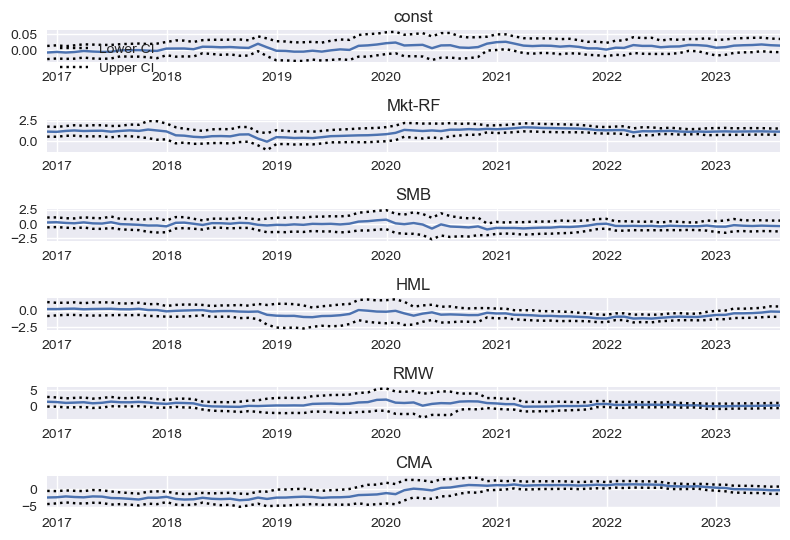

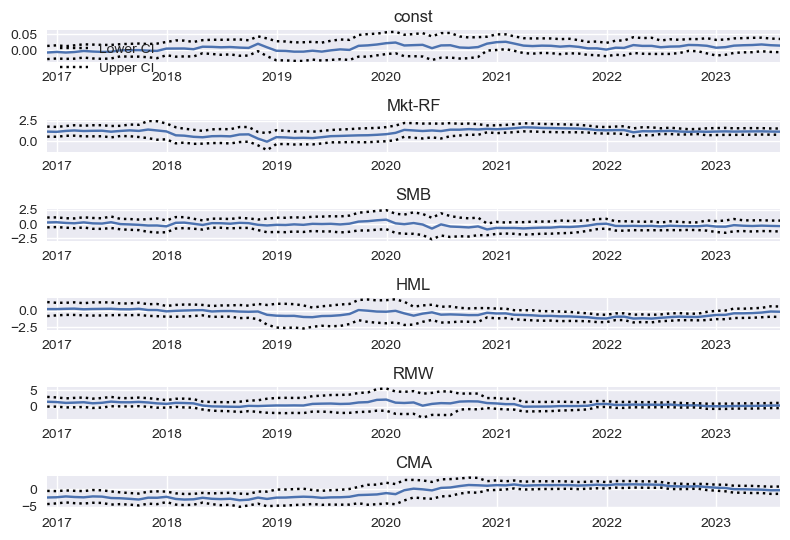

In [108]:
# Plot with confidence intervals for the coefficient

r_OLS.plot_recursive_coefficient()

In [109]:
# This plots the coefficient values for the windows of time used in the RollingOLS model associated with
# The French-Fama factors used to predict returns on stocks.

# r_OLS.plot_recursive_coefficient(variables=dropped_df.drop(columns="return_1m").columns, alpha=False)

In [110]:
factors = dropped_df.xs("AAPL", level=1).drop(columns="return_1m")

predictions = []
for row in betas.xs("AAPL", level=1).index:
    iterations = []
    for i in betas.columns:
        product = betas.xs("AAPL", level=1).loc[row, i] * factors.loc[row, i]
        iterations.append(product)
    predictions.append(sum(iterations))
    

In [111]:
# I think these are the predicted return values of AAPL on monthly basis as determined by using RollingOLS

predictions[-10:]
zipper = list(zip(predictions, betas.xs("AAPL", level=1).index))
zipper[20:25]

[(nan, Timestamp('2016-08-31 00:00:00')),
 (nan, Timestamp('2016-09-30 00:00:00')),
 (nan, Timestamp('2016-10-31 00:00:00')),
 (0.009516575989677659, Timestamp('2016-11-30 00:00:00')),
 (0.05434610942295648, Timestamp('2016-12-31 00:00:00'))]

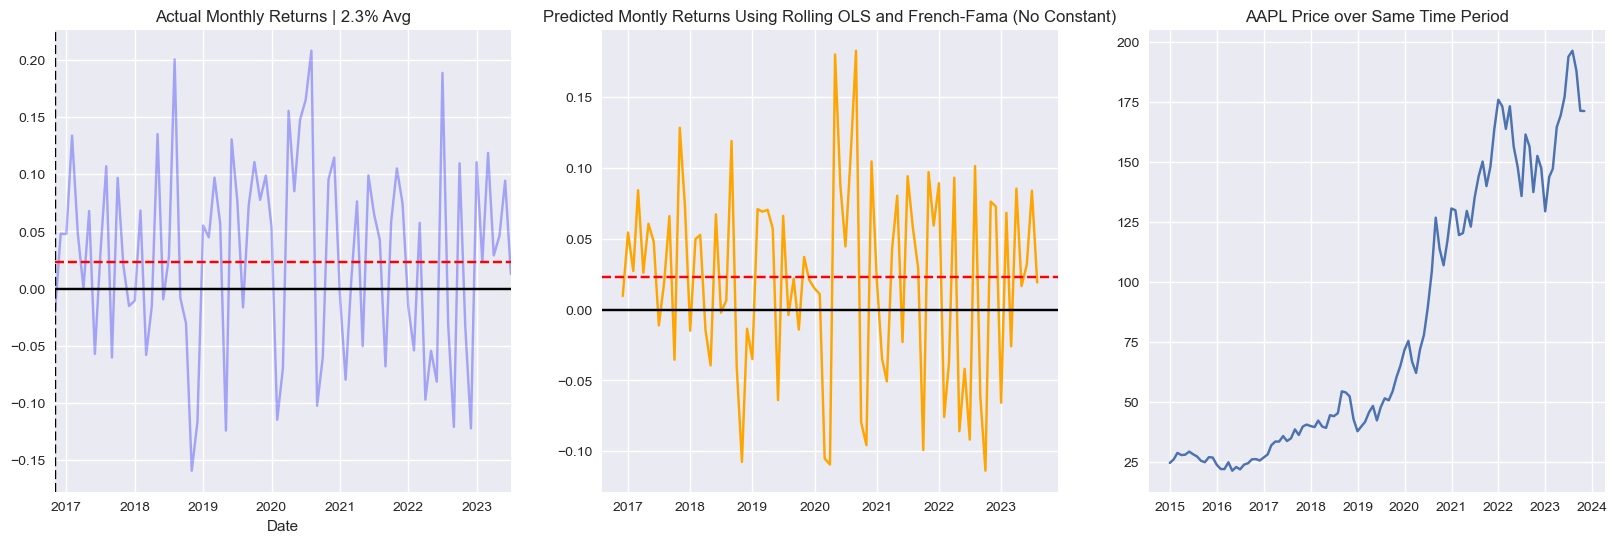

In [112]:
fig, ax = plt.subplots(ncols = 3,figsize=(20,6))
dropped_df.xs("AAPL", level=1).loc['2016-11-30 00:00:00':, "return_1m"].plot(kind='line', ax=ax[0], label="True Values", color="blue", alpha=.3)
ax[0].axhline(dropped_df.xs("AAPL", level=1)["return_1m"].mean(), color='red', linestyle="--")
ax[0].axhline(0, color='black', linestyle="-")
ax[0].axvline('2016-11-30 00:00:00', color="black", linestyle="--")


ax[1].plot(betas.xs("AAPL", level=1).index , predictions, color='orange', label="Predictions")
ax[1].axhline(dropped_df.xs("AAPL", level=1)["return_1m"].mean(), color='red', linestyle="--")
ax[1].axhline(0, color='black', linestyle="-")
ax[1].set_title("Predicted Montly Returns Using Rolling OLS and French-Fama (No Constant)")



ax[0].set_title(f"Actual Monthly Returns | {round(dropped_df.xs('AAPL', level=1)['return_1m'].mean(), 3)*100}% Avg")
ax[2].plot(top150.xs("AAPL", level=1).loc['2014-12-31':, "Adj Close"])
ax[2].set_title("AAPL Price over Same Time Period");

Initial observations are that the French-Fama regression seems to under-estimate monthly returns, but there is no constant added in these predictions either. This is a very small sample size, so probably adviseable not to overvalue these results.

In [113]:
dropped_df.xs("AAPL", level=1).drop(columns="return_1m").loc['2017-10-31':]

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2017-10-31,0.0225,-0.0194,0.0020,0.0093,-0.0325
2017-11-30,0.0312,-0.0033,-0.0003,0.0316,-0.0005
2017-12-31,0.0106,-0.0107,0.0006,0.0074,0.0169
2018-01-31,0.0557,-0.0318,-0.0129,-0.0076,-0.0096
2018-02-28,-0.0365,0.0032,-0.0104,0.0052,-0.0237
...,...,...,...,...,...
2023-03-31,0.0251,-0.0694,-0.0885,0.0224,-0.0237
2023-04-30,0.0061,-0.0256,-0.0004,0.0242,0.0286
2023-05-31,0.0035,-0.0038,-0.0772,-0.0181,-0.0722


In [114]:
# Struggled to extract predictions based on these betas

betas.xs("AAPL", level=1)[betas.xs("AAPL", level=1).notna()]

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2014-12-31,NaN,NaN,NaN,NaN,NaN
2015-01-31,NaN,NaN,NaN,NaN,NaN
2015-02-28,NaN,NaN,NaN,NaN,NaN
2015-03-31,NaN,NaN,NaN,NaN,NaN
2015-04-30,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2023-03-31,1.172815,-0.267164,-0.358052,0.193518,-0.055486
2023-04-30,1.181496,-0.313048,-0.320197,0.188609,-0.119265
2023-05-31,1.189384,-0.253707,-0.239683,0.239541,-0.171251


An issue that we have with our betas are that the French Fama is that we are identifying them for the end of the month, therefore, they would be associated with the entire following month of real stock data. In other words something that we calculated at month's end would have no bearing on the previous month, but will help with future data. We should, therefore, shift the FF data forward by one month, because the regressions/coefficients are only determined at month's end.

In [115]:
# Shifting the data forward by 1 month and re-joining it to our original data.

DF_w_betas = top150.join(betas.groupby("Ticker").shift())

# NEW DF OBJECT AGAIN

In [116]:
DF_w_betas.head(2)

Adj Close  garman_klass_vol        RSI  \
Date       Ticker                                           
2014-11-30 AAL     45.982338          0.001106  71.781405   
           AAPL    26.649851         -0.004808  75.927592   

                   lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Date       Ticker                                                            
2014-11-30 AAL                 38.748957             40.092589   41.436220   
           AAPL                23.525069             24.414897   25.304726   

                   one_up_bollinger_band  upper_bollinger_band       ATR  \
Date       Ticker                                                          
2014-11-30 AAL                 42.779851             44.123482  1.657980   
           AAPL                26.194555             27.084384  0.470102   

                       MACD  return_1m  return_2m  return_3m  return_6m  \
Date       Ticker                                                         
2014-11-30 AAL     1.776186        NaN        NaN        NaN        NaN   
           AAPL    0.865696        NaN        NaN        NaN        NaN   

                   return_9m  return_12m  Mkt-RF  SMB  HML  RMW  CMA  
Date       Ticker                                                     
2014-11-30 AAL           NaN         NaN     NaN  NaN  NaN  NaN  NaN  
           AAPL          NaN         NaN     NaN  NaN  NaN  NaN  NaN

In [117]:
betas.head(1)

,,Mkt-RF,SMB,HML,RMW,CMA
Date,Ticker,,,,,
2014-12-31,AAL,NaN,NaN,NaN,NaN,NaN


In [118]:
DF_w_betas.shape, top150.shape, betas.shape

((16200, 21), (16200, 16), (15516, 5))

In [119]:
# Imputing the missing data for the 5 Factor Coefficient columns

factor_cols = list(betas.columns)

# Filling the null values with each respective ticker's mean() values for that particular column

# This could be construed as data leakage, but I will wait to see how it is handled in future modeling


DF_w_betas.loc[:, factor_cols] = DF_w_betas.groupby('Ticker', group_keys=False).apply(lambda x: x.fillna(x.mean()))

In [120]:
# After Filling the null values 

DF_w_betas.shape, DF_w_betas.isna().sum()

((16200, 21),
 Adj Close                   0
 garman_klass_vol            0
 RSI                         0
 lowest_bollinger_band       0
 lower_bollinger_band        0
 20_day_SMA                  0
 one_up_bollinger_band       0
 upper_bollinger_band        0
 ATR                         0
 MACD                        0
 return_1m                 200
 return_2m                 400
 return_3m                 599
 return_6m                1183
 return_9m                1755
 return_12m               2324
 Mkt-RF                    280
 SMB                       280
 HML                       280
 RMW                       280
 CMA                       280
 dtype: int64)

In [121]:
# All of these entries have 24 or fewer months worth of data, and our specified window for the model was:
# min(24, x.shape[0]) -> in this instance, x.shape[0] < 24 for all of these stocks, and they were without coefs

DF_w_betas[DF_w_betas["SMB"].isna()].groupby("Ticker")['Adj Close'].agg('count')

Ticker
ABNB    23
ALGN    24
BKR      7
BX       3
CF       4
CMI     21
CTRA     7
DUK     21
DXCM     3
ENPH    14
EQIX     2
ETN      5
ETSY    21
EXC     20
FSLR    13
HPE      3
ICE      6
KLAC    12
NCLH    24
NSC     15
PLD      5
TRV     11
URI     16
Name: Adj Close, dtype: int64

In [122]:
# Dropping the null values once again just to have a complete data set

total_df = DF_w_betas.dropna()

In [123]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 13796 entries, (Timestamp('2015-11-30 00:00:00'), 'AAL') to (Timestamp('2023-10-31 00:00:00'), 'XOM')
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Adj Close              13796 non-null  float64
 1   garman_klass_vol       13796 non-null  float64
 2   RSI                    13796 non-null  float64
 3   lowest_bollinger_band  13796 non-null  float64
 4   lower_bollinger_band   13796 non-null  float64
 5   20_day_SMA             13796 non-null  float64
 6   one_up_bollinger_band  13796 non-null  float64
 7   upper_bollinger_band   13796 non-null  float64
 8   ATR                    13796 non-null  float64
 9   MACD                   13796 non-null  float64
 10  return_1m              13796 non-null  float64
 11  return_2m              13796 non-null  float64
 12  return_3m              13796 non-null  float64
 13  return_6m              13796 n

### Preparation for machine learning:
We will now attempt to rebalance out portfolio on a monthly basis to include only the stocks which are most likely to perform the very best. We can also treat the Adj Close variable in most cases as a target value. 

In [124]:
# 177 unique stock tickers in our data, we will have the top 150 most liquid (volume * price), per month

len(total_df.index.get_level_values(1).unique())

177

### Identifying clusters in the stock market data we have left

# Saving the data for less memory usage within this notebook, i can skip to here

In [125]:
# Saving for memory purposes

total_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/stocks_for_modeling_clusters.csv')

In [126]:
first_month = total_df.loc["2015-11-30"]
first_month.shape

(132, 21)

In [135]:
# Saving for memory purposes

first_month.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/first_month_for_clusters.csv')

# At this point within the notebook, everything tends to get a bit stretched, so I am starting a new notebook from this point on.

In [ ]:
first_month = total_df.loc["2015-11-30"]
from sklearn.metrics import silhouette_score
silhouttes = []
inertias = []

for i in range(1, 7):
    clusters = KMeans(n_clusters=i, random_state=42, init='random')
    clusters.fit(first_month)
    silhouttes.append(silhouette_score(first_month, clusters.predict(first_month)))
    inertias.append(clusters.inertia_)
        
    
fig, ax = plt.subtplots(ncols=2, figsize=(16,6))
ax[0].plot(range(1,7), silhouttes)
ax[0].set_title("Silhoutte Scores for Various # of Clusters")

ax[1].plot(range(1,7), inertias)
ax[1].set_title("Inertia Plots")

In [ ]:
sil_score = []
for n_clusters in range(2,10):
    agg_preds = AgglomerativeClustering(n_clusters=n_clusters).fit_predict(X_iris)
    sil_score.append(silhouette_score(X_iris, agg_preds))
    

# Extracting date time as a feature

In [ ]:
# Using df.index and "get_level_values()" and index 0 in order to extract the date times of the observations for 
# additional feature engineering
observation_dates = df.index.get_level_values(0)

In [ ]:
# matches the length of the data frame
len(observation_dates)

In [ ]:
df.shape

In [ ]:
df["Date"] = observation_dates

In [ ]:
# Visual Inspection of the Data
df.head(2)

In [ ]:
# Confirmation of datetime64 object
df.info()

In [ ]:
# Label the quarters of the year

df["Quarter"] = df["Date"].dt.quarter

In [ ]:
# Numeric Values for the Days of the Week

df["Date"].dt.dayofweek

In [ ]:
# dt.strftime() -> '%A' for day, '%B' for month preferable for OHE values as opposed to ordinally defaulted values

df["Day_of_the_Week"] = df['Date'].dt.strftime('%A')

In [ ]:
df["Month"] = df['Date'].dt.strftime('%B')

In [ ]:
df['Date'].dt.strftime('%B')

In [ ]:
df["Year"] = df["Date"].dt.year

In [ ]:
# Inspecting the data

df.iloc[3333:3344, :]

In [ ]:
df["Day_of_the_Week"].value_counts()

In [ ]:
df["Month"].value_counts()

In [ ]:
df["Year"].value_counts()

In [ ]:
df.loc["2014-10-10"]

In [ ]:
# Attempting to engineer one target value for whether a stock has gone up in value a month later
df.groupby(level=1)["Adj Close"] < df.groupby(level=1)["Adj Close"]

In [ ]:
df.head(2)

### SHIFT()

In [ ]:
# Investigating how .shift() works
df['Adj Close'].shift(-20)

In [ ]:
df["Adj Close"].iloc[19:27]

### Creating a function to handle the shifts in DateTimes

### Creating a list of dates in the dataframe

In [ ]:
# .index.get_level_values(0) gets the information for that level of the index

dates = df.index.get_level_values(0).unique()

In [ ]:
df.loc[("2013-10-28", ["A", "AAPL", "GOOGL"]), :]

In [ ]:
symbol = df.index.get_level_values(1).unique()
symbol

# First Revision

In [ ]:
def twenty_day_target_assessor(df, dates, stock_symbol):
    # Create an empty list to store the target values
    targets = []

    # Iterate through the DataFrame for the given stock symbol
    for date, row in df.xs(stock_symbol, level="Symbol").iterrows():
        current_price = row["Adj Close"]

        # Find the index of the current date in the list of unique dates
        date_index = dates.get_loc(date)

        # Calculate the future date that is 20 days later
        future_date_index = date_index + 20

        # Check if sufficient data is available for calculating the target
        if future_date_index < len(dates):
            future_date = dates[future_date_index]
            future_price = df.loc[(future_date, stock_symbol)]["Adj Close"]

            # Determine the target value
            target = int(future_price > current_price)
            targets.append(target)
        else:
            # If there's not enough data for the next 20 days, mark it as unknown (NaN)
            targets.append(None)

    return targets

# Example usage:
dates = df.index.get_level_values(0).unique()
stock_symbol = "AAPL"  # Replace with the stock symbol you're interested in
targets = twenty_day_target_assessor(df, dates, stock_symbol)
df[f"Target_{stock_symbol}"] = targets

# I think this might work for the .transform() method

In [ ]:
# Define the twenty_day_target_assessor function
def twenty_day_target_assessor(data):
    current_price = data["Adj Close"]
    current_date = data.index.get_level_values(0)[0]
    date_index = dates.get_loc(current_date)
    future_date_index = date_index + 20

    if future_date_index < len(dates):
        future_date = dates[future_date_index]
        future_price = df.loc[(future_date, data.index.get_level_values(1)[0])]["Adj Close"]
        return int(future_price > current_price)
    else:
        return None

# Group the data by 'Symbol' and apply the transformation
df['Target'] = df.groupby('Symbol').transform(twenty_day_target_assessor)

# Other attempt: debugging efforts as well

In [ ]:
# Draft:

# def twenty_day_target_assessor(row):
#     current_price = row["Adj Close"]
#     current_date = row["Date"]
#     date_index = dates.get_loc(current_date)
#     future_date = dates[date_index+20]
#     future_price = df.loc[future_date]["Adj Close"]
#     return (future_price > current_price).astype(int)

In [ ]:
twenty_days_later = []
for i in range(len(dates)):
    twenty_days_later.append(twenty_day_target_assessor(df.iloc[i]))

In [ ]:
twenty_up_or_not = []
for i in twenty_days_later:
    for j in i:
        twenty_up_or_not.append(j)
        

In [ ]:
len(twenty_up_or_not)

In [ ]:
twenty_up_or_not[-10:]

In [ ]:
df["20 Days Later"] = twenty_days_later

In [ ]:
df.iloc[0].get

# Checking the validity of this function

In [ ]:
# Price of Apple on the first day of our data

print("Now:", df.xs("AAPL", level=1).loc["2013-10-28"]["Adj Close"])

# Price of apple 20 days later

print("20 Days Later:", df.xs("AAPL", level=1).loc["2013-11-25"]["Adj Close"])

In [ ]:
# Price of Apple on the first day of our data

print("Now:", df.xs("A", level=1).loc["2013-10-28"]["Adj Close"])

# Price of apple 20 days later

print("20 Days Later:", df.xs("A", level=1).loc["2013-11-25"]["Adj Close"])

In [ ]:
# Price of Apple on the first day of our data

print("Now:", df.xs("YUM", level=1).loc["2013-10-28"]["Adj Close"])

# Price of apple 20 days later

print("20 Days Later:", df.xs("YUM", level=1).loc["2013-11-25"]["Adj Close"])

In [ ]:
# Price of Apple on the first day of our data

print("Now:", df.xs("ZBRA", level=1).loc["2013-10-28"]["Adj Close"])

# Price of apple 20 days later

print("20 Days Later:", df.xs("ZBRA", level=1).loc["2013-11-25"]["Adj Close"])

### Testing function out for identifying future values
Looks good at the moment, going to try it on the whole dataframe.

In [ ]:
df.groupby(level=1).apply(twenty_day_target_assessor)

In [ ]:
# Current date + pd.offsets.BDay works for creating a specified interval of business days
pd.to_datetime("2013-10-28") + pd.offsets.BDay(20)

In [ ]:
dates = df.index.get_level_values(0).unique()

In [ ]:
len(dates)

In [ ]:
df.shape

# This is how you find out the index of a given date. get_loc() 

In [ ]:
dates.get_loc('2013-11-25')

In [ ]:
dates.get_loc("2013-10-28")

In [ ]:
df.index[2][0]

In [ ]:
df.xs("AAPL", level=1).iloc[0]["Adj Close"]

# Checking the validity of this function - still work in progress

In [ ]:
# Price of Apple on the first day of our data

print("Now:", df.xs("AAPL", level=1).loc["2013-10-28"]["Adj Close"])

# Price of apple 20 days later

print("20 Days Later:", df.xs("AAPL", level=1).loc["2013-11-25"]["Adj Close"])

In [ ]:
# Range of Dates in our Data

df["Date"].agg(['min', 'max'])

In [ ]:
# Price of apple 20 days later

df.xs("AAPL", level=1).loc["2013-11-25"]["Adj Close"]

In [ ]:
# Creating an object for the entirety of the dates we have info from
original_dates = pd.date_range(start='2013-10-28', end='2023-10-25', freq='B')

In [ ]:
# Create a date range for dates 20 trading days later
future_dates = original_dates + pd.DateOffset(days=20)
future_dates

In [ ]:
for original_date, future_date in zip(original_dates, future_dates):
    original_data = df.loc[original_date]
    future_data = df.loc[future_date]
    print(f"Original Date: {original_date}")
    print(f"Original Data: {original_data['StockPrice']}")
    print(f"Future Date: {future_date}")
    print(f"Future Data: {future_data['StockPrice']}")
    print(f"PriceHigher20DaysLater: {original_data['PriceHigher20DaysLater']}")
    print("\n")

In [ ]:
future_data = df.loc[df.index[:][0] + pd.DateOffset(days=20)]

In [ ]:
# Calculate the future price 20 trading days after the current observation
df['FuturePrice'] = df['StockPrice'].shift(-20)

# Create a feature column based on the comparison
df['PriceHigher20DaysLater'] = df['FuturePrice'] >= df['StockPrice']


# From an outside resource that David Directed me to

In [ ]:
outside_CNN_data = pd.read_csv("/Users/samalainabayeva/Desktop/Capstone Project/Dataset/Processed_NASDAQ.csv")

In [ ]:
outside_CNN_data.shape

In [ ]:
outside_CNN_data.head()

In [ ]:
outside_CNN_data["Date"].agg(['min', 'max'])

# Loading SPDR Data - will process elsewhere

In [137]:
start_date

Timestamp('2013-10-28 00:00:00')

In [127]:
sector_spdrs = ["XLB", "XLC", "XLY", "XLP", 'XLE', "XLF", 'XLV', "XLI", "XLK", "XLU", "XLRE"]

In [155]:
spdr_df = yf.download(sector_spdrs, start='1998-12-22', end=end_date)

[*********************100%%**********************]  11 of 11 completed


In [156]:
spdr_df = spdr_df.stack()

In [157]:
spdr_df.shape

(59633, 6)

In [158]:
spdr_df.head(12)

Adj Close      Close       High        Low       Open  \
Date                                                                    
1998-12-22 XLB  12.011767  20.828125  20.828125  20.750000  20.781250   
           XLE  12.448157  23.265625  23.390625  23.187500  23.312500   
           XLF  11.612926  18.937855  19.052092  18.849005  19.052092   
           XLI  14.971390  23.281250  23.281250  23.203125  23.203125   
           XLK  24.243126  32.046875  32.500000  31.781250  32.406250   
           XLP  14.967611  26.500000  26.531250  25.875000  25.875000   
           XLU  12.582784  29.828125  30.250000  29.828125  30.250000   
           XLV  17.505878  25.031250  25.062500  24.812500  24.812500   
           XLY  19.151007  25.468750  25.468750  25.312500  25.312500   
1998-12-23 XLB  12.137930  21.046875  21.140625  20.968750  20.968750   
           XLE  12.707324  23.750000  23.750000  23.312500  23.343750   
           XLF  11.784163  19.217100  19.217100  18.861698  18.861698   

                  Volume  
Date                      
1998-12-22 XLB    1900.0  
           XLE   15200.0  
           XLF   55887.0  
           XLI     600.0  
           XLK  300500.0  
           XLP  150300.0  
           XLU    7900.0  
           XLV    5700.0  
           XLY    3700.0  
1998-12-23 XLB     700.0  
           XLE   67800.0  
           XLF   78784.0

In [159]:
# export the csv file

# spdr_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/SPDRs.csv')

# Major Index Data - will process/engineer elsewhere

In [4]:
indeces = ["^RUT", "^IXIC", "^GSPC", "^DJI"]

In [5]:
index_df = yf.download(indeces, start='1964-01-02', end='2023-11-03')

[*********************100%%**********************]  4 of 4 completed


In [6]:
index_df = index_df.stack()

In [7]:
index_df.head()

,,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,,
1964-01-02,^GSPC,75.430000,75.430000,75.790001,74.820000,0.0,4680000.0
1964-01-03,^GSPC,75.500000,75.500000,76.040001,75.089996,0.0,5550000.0
1964-01-06,^GSPC,75.669998,75.669998,76.120003,75.180000,0.0,5480000.0
1964-01-07,^GSPC,75.690002,75.690002,76.239998,75.250000,0.0,5700000.0
1964-01-08,^GSPC,76.000000,76.000000,76.349998,75.389999,0.0,5380000.0


In [8]:
index_df.index.rename(["Date", "Index"], inplace=True)

In [9]:
index_df.head()

,,Adj Close,Close,High,Low,Open,Volume
Date,Index,,,,,,
1964-01-02,^GSPC,75.430000,75.430000,75.790001,74.820000,0.0,4680000.0
1964-01-03,^GSPC,75.500000,75.500000,76.040001,75.089996,0.0,5550000.0
1964-01-06,^GSPC,75.669998,75.669998,76.120003,75.180000,0.0,5480000.0
1964-01-07,^GSPC,75.690002,75.690002,76.239998,75.250000,0.0,5700000.0
1964-01-08,^GSPC,76.000000,76.000000,76.349998,75.389999,0.0,5380000.0


In [10]:
index_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Indices_back_to_1964.csv')